In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# <center> <h1 style="background-color:red; color:white" >HOUSE - PRICE (GBM) &#127969;</h1>
<center><img
src="https://cdn-res.keymedia.com/cms/images/au/136/0369_637363244143884094.jpg"
style="width:90%;height:40%;">
</center>   

# <center> <h1 style="background-color:red; color:white" >Import Libraries &#128218;</h1>
<center>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn import preprocessing

# Models 
# -----------------------------------
import lightgbm as lgb
import xgboost
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
# Metrics & Evaluation
# -----------------------------------
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

In [3]:
df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")

In [4]:
df_test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")

# <center> <h1 style="background-color:red; color:white" >Functions</h1>
<center>

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.

    return cat_cols, cat_but_car, num_cols, num_but_cat

In [6]:
def cat_summary(dataframe, col_name, hue_, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe, hue=hue_)
        plt.show()

In [7]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

In [8]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

In [9]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

**Missing Value Analysis**

In [10]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

**Other Missing Value**

In [11]:
def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if
                         data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x,
                      axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data

**Rare Analyser**

In [12]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [13]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

In [14]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# <center> <h1 style="background-color:red; color:white" >Data</h1>
<center>

In [15]:
df = df_train.append(df_test).reset_index(drop=True)
df.shape

(2919, 81)

In [16]:
df.value_counts(np.where(df["SalePrice"]>0,'1','0'))

1    1460
0    1459
dtype: int64

# <center> <h1 style="background-color:red; color:white" >Missing Values</h1>
<center>

In [17]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 81
cat_cols: 52
num_cols: 28
cat_but_car: 1
num_but_cat: 10


<center> <h1 style="background-color:red; color:white" >Categorical Columns</h1><center>

In [18]:
def cat_summary(dataframe, col_name, plot=False):

    if plot:
        
        plt.figure(figsize=(6,4))
        plt.subplot(2,1,1)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        
        
        plt.figure(figsize=(6,4))
        plt.subplot(2,1,2)
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.ylim([0,100])
        plt.show()
        
        
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        

In [19]:
def cat_summary(dataframe, col_name, plot=False):
    
    if plot:
        
        plt.figure(figsize=(15,5))
        sns.countplot(x=dataframe[col_name], data=dataframe, palette='rocket')
        plt.title(col_name + "_Orjinal",fontsize=20)
        
        plt.figure(figsize=(15,5))
        sns.countplot(x=dataframe[col_name], data=dataframe, palette='rocket')
        plt.ylim([0,100])
        plt.title(col_name + "_Resize",fontsize=20)
        plt.show()
        
        
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

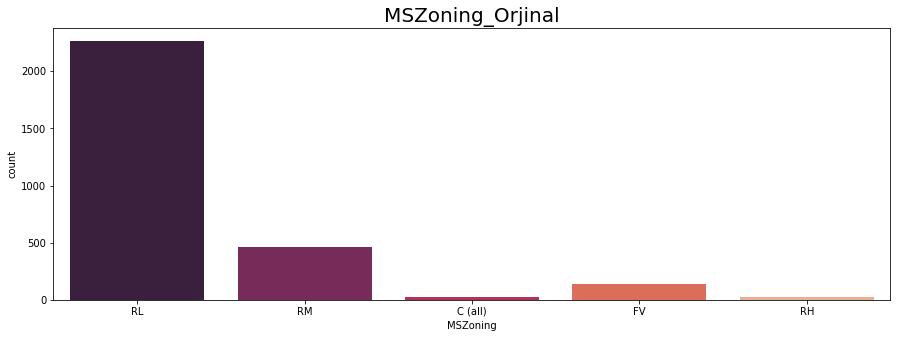

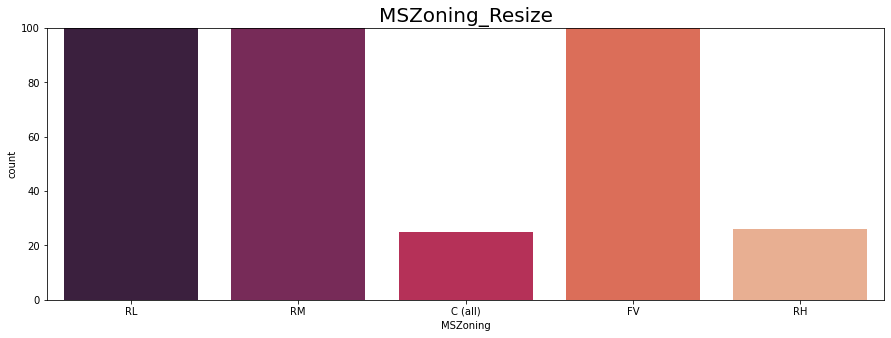

         MSZoning      Ratio
RL           2265  77.595067
RM            460  15.758822
FV            139   4.761905
RH             26   0.890716
C (all)        25   0.856458


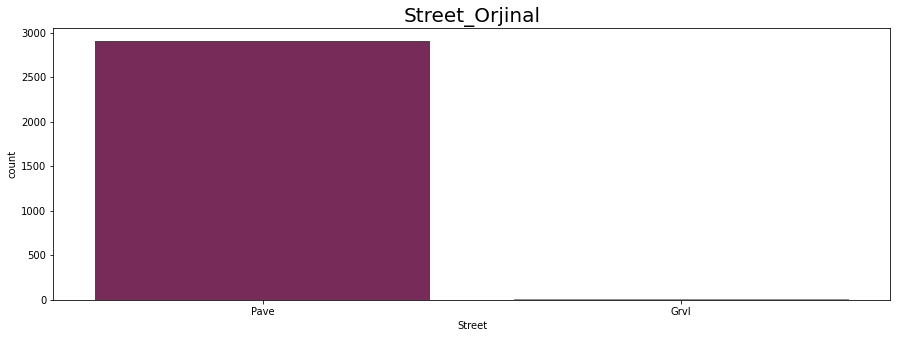

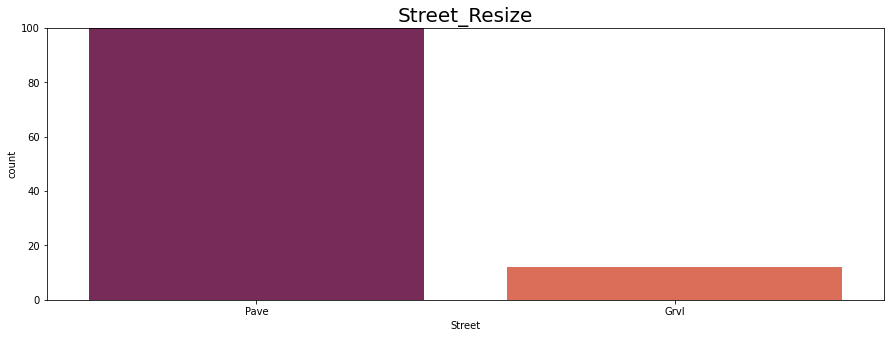

      Street    Ratio
Pave    2907  99.5889
Grvl      12   0.4111


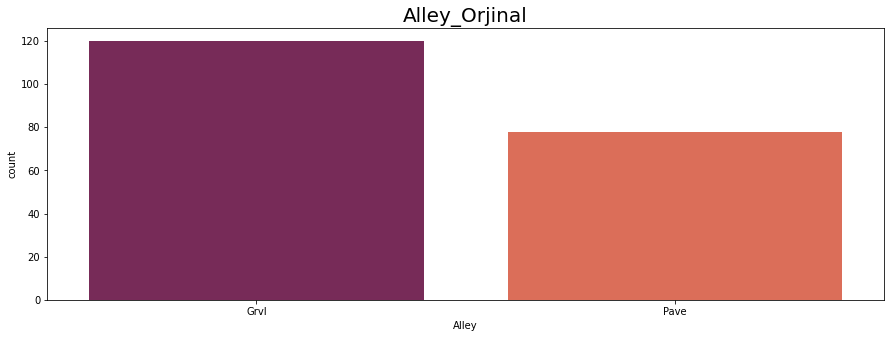

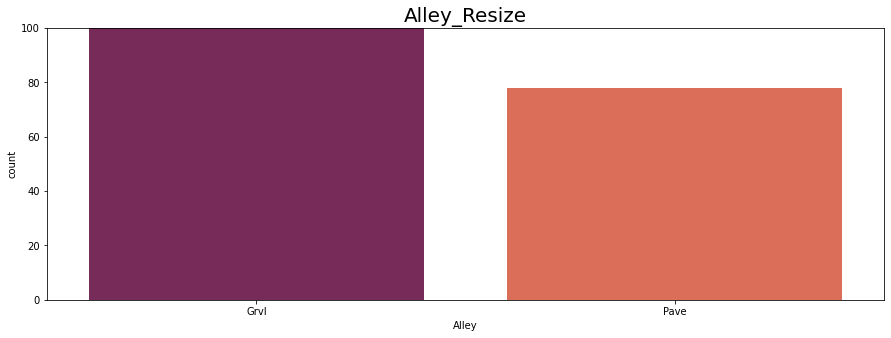

      Alley     Ratio
Grvl    120  4.110997
Pave     78  2.672148


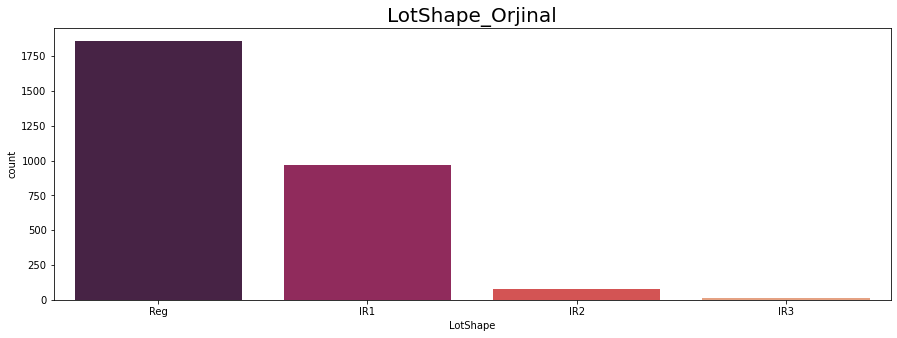

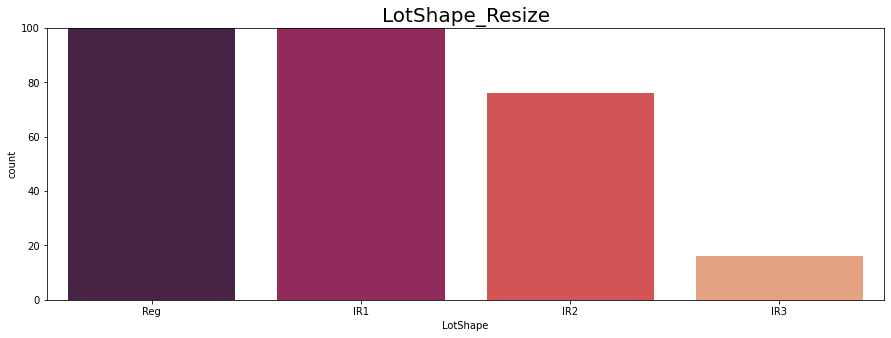

     LotShape      Ratio
Reg      1859  63.686194
IR1       968  33.162042
IR2        76   2.603631
IR3        16   0.548133


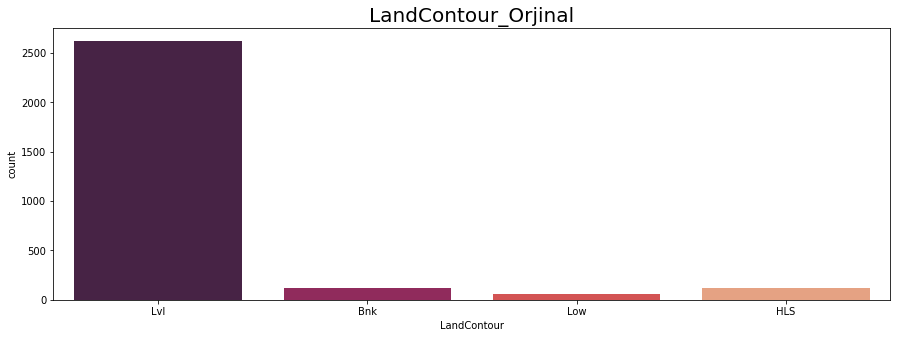

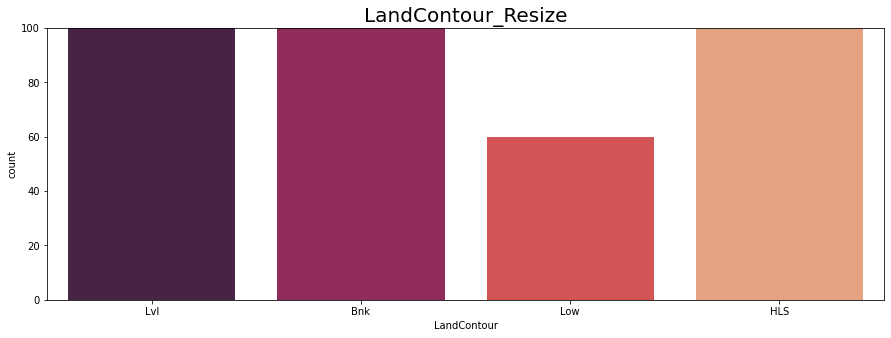

     LandContour      Ratio
Lvl         2622  89.825283
HLS          120   4.110997
Bnk          117   4.008222
Low           60   2.055498


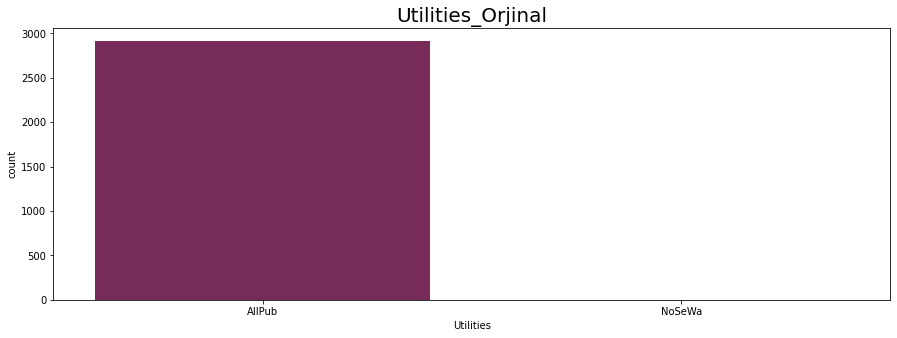

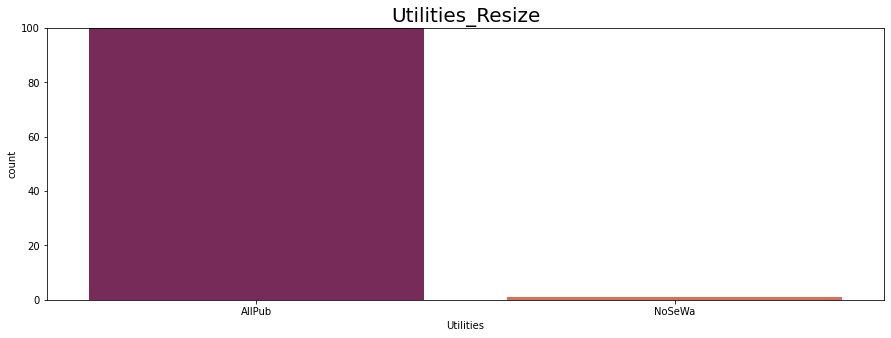

        Utilities      Ratio
AllPub       2916  99.897225
NoSeWa          1   0.034258


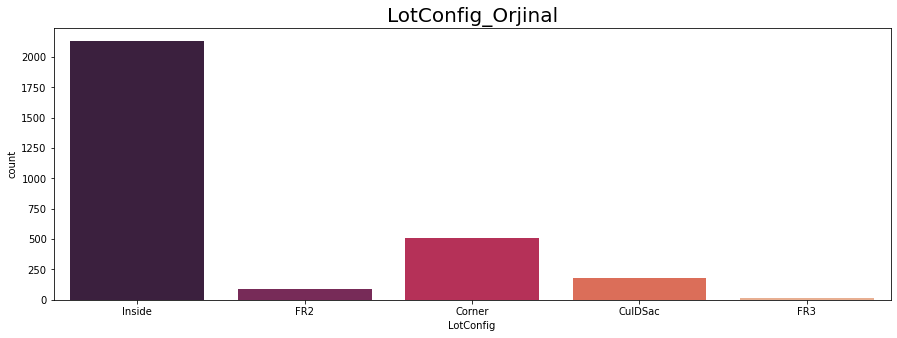

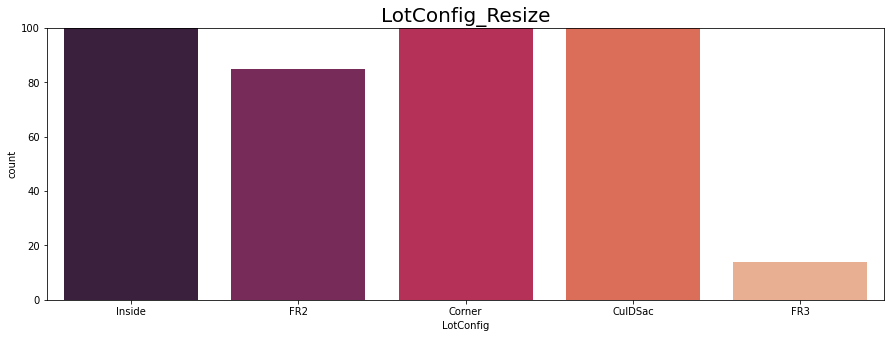

         LotConfig      Ratio
Inside        2133  73.072970
Corner         511  17.505995
CulDSac        176   6.029462
FR2             85   2.911956
FR3             14   0.479616


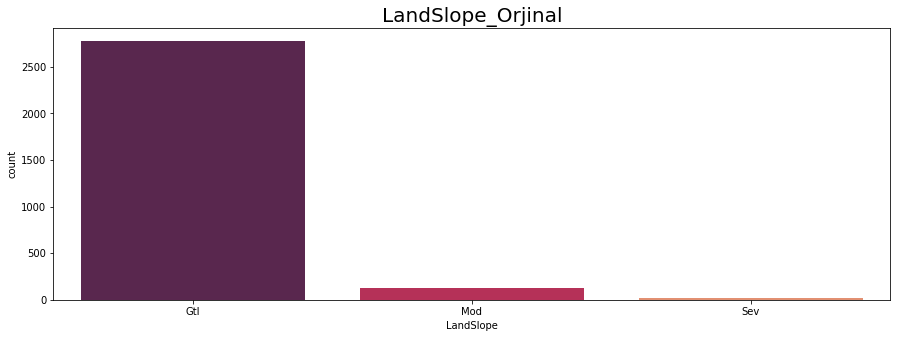

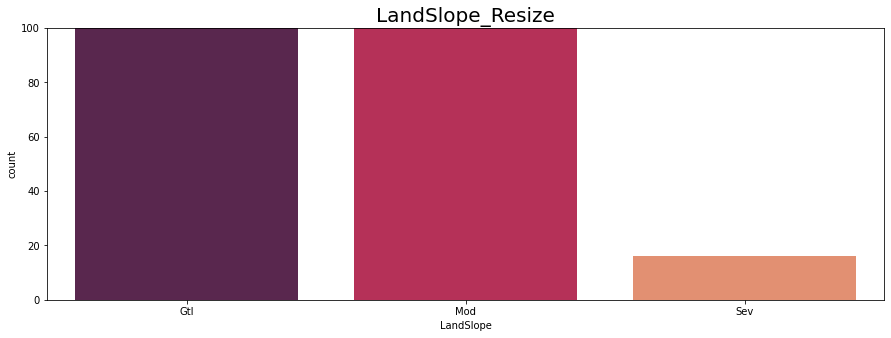

     LandSlope      Ratio
Gtl       2778  95.169579
Mod        125   4.282288
Sev         16   0.548133


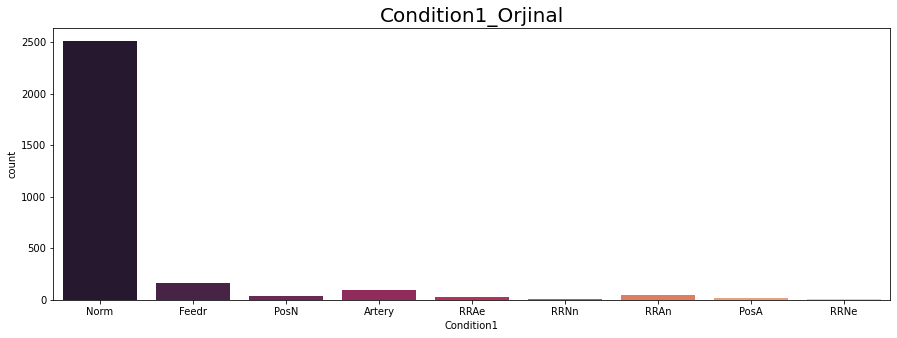

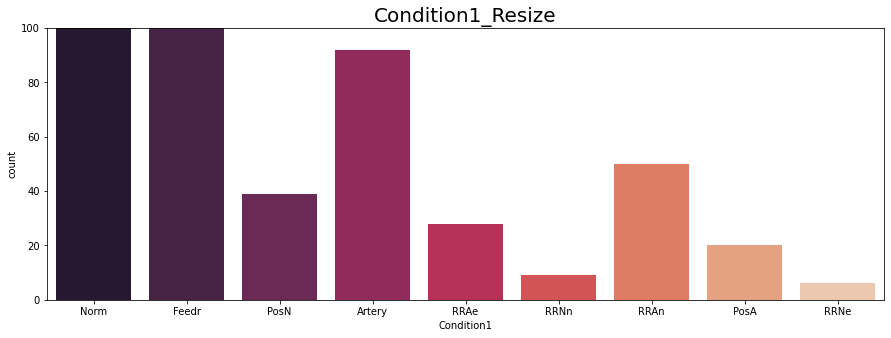

        Condition1      Ratio
Norm          2511  86.022610
Feedr          164   5.618362
Artery          92   3.151764
RRAn            50   1.712915
PosN            39   1.336074
RRAe            28   0.959233
PosA            20   0.685166
RRNn             9   0.308325
RRNe             6   0.205550


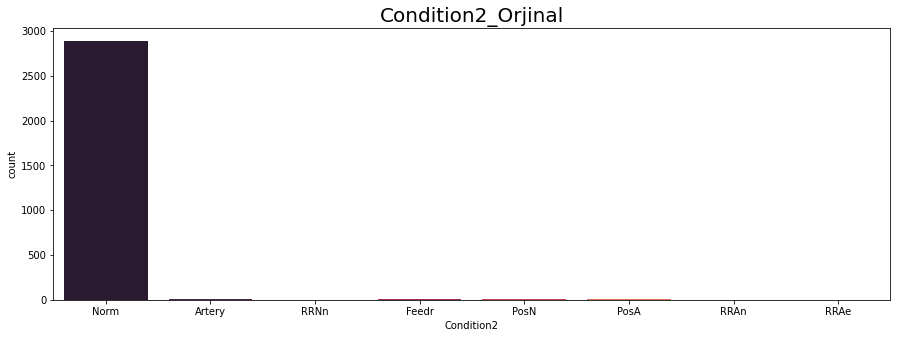

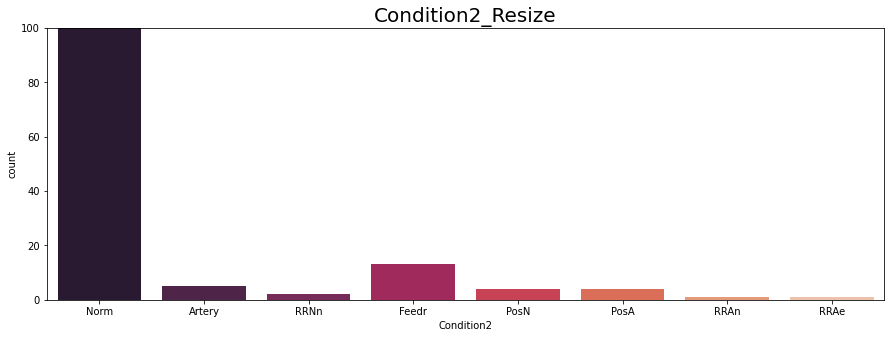

        Condition2      Ratio
Norm          2889  98.972251
Feedr           13   0.445358
Artery           5   0.171292
PosN             4   0.137033
PosA             4   0.137033
RRNn             2   0.068517
RRAn             1   0.034258
RRAe             1   0.034258


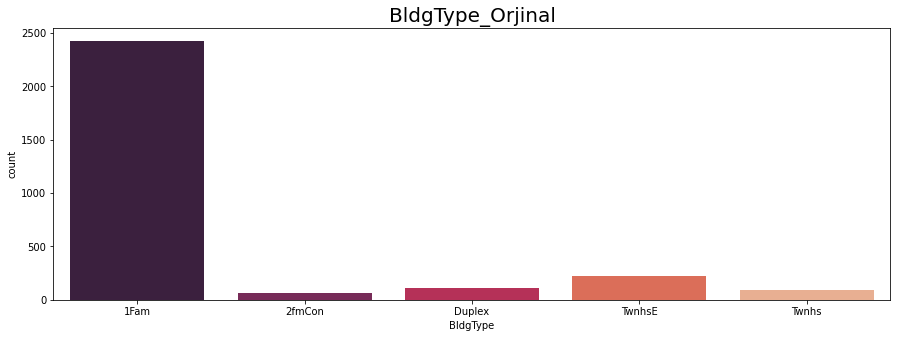

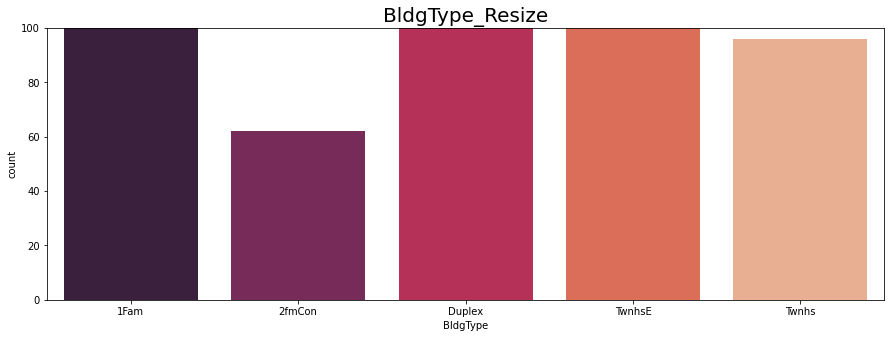

        BldgType      Ratio
1Fam        2425  83.076396
TwnhsE       227   7.776636
Duplex       109   3.734156
Twnhs         96   3.288798
2fmCon        62   2.124015


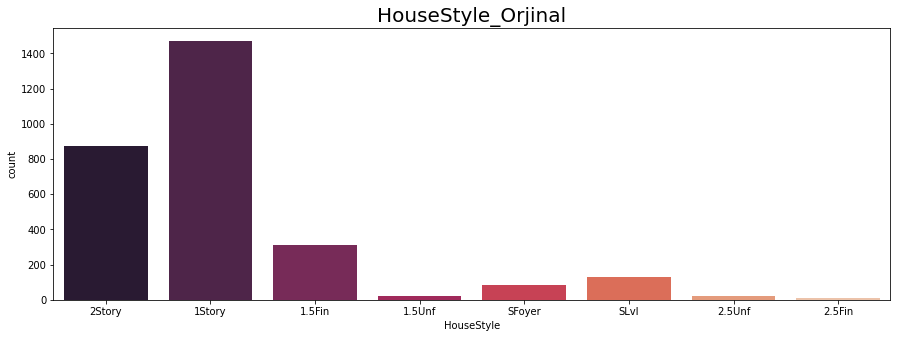

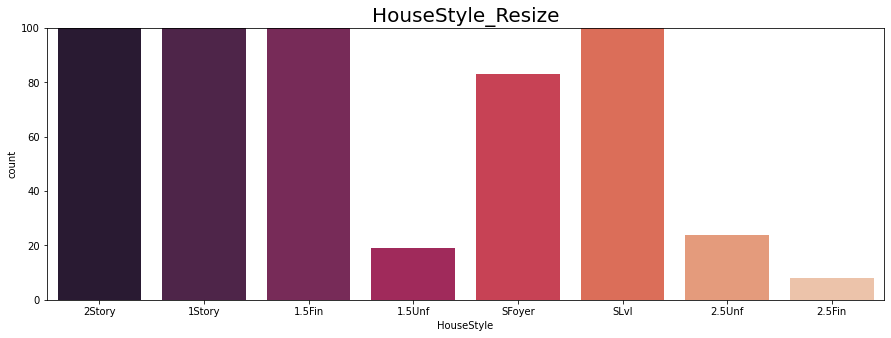

        HouseStyle      Ratio
1Story        1471  50.393971
2Story         872  29.873244
1.5Fin         314  10.757109
SLvl           128   4.385063
SFoyer          83   2.843440
2.5Unf          24   0.822199
1.5Unf          19   0.650908
2.5Fin           8   0.274066


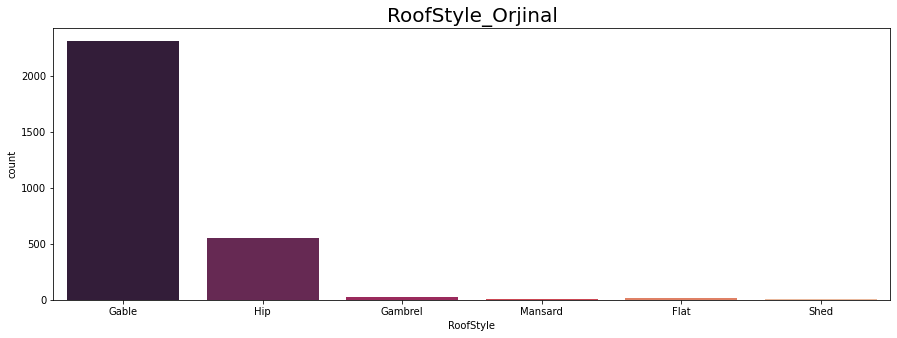

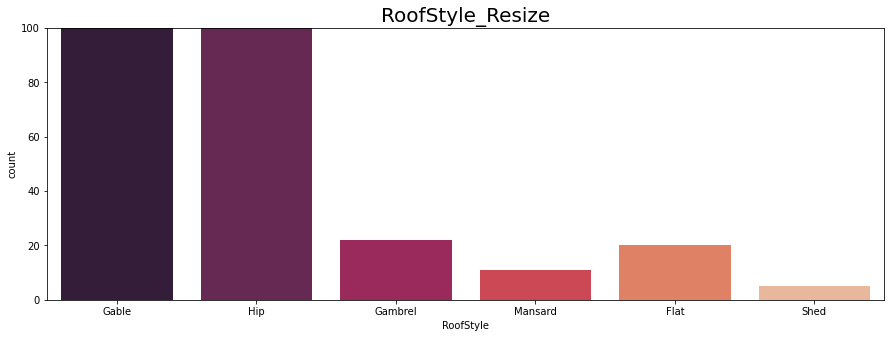

         RoofStyle      Ratio
Gable         2310  79.136691
Hip            551  18.876328
Gambrel         22   0.753683
Flat            20   0.685166
Mansard         11   0.376841
Shed             5   0.171292


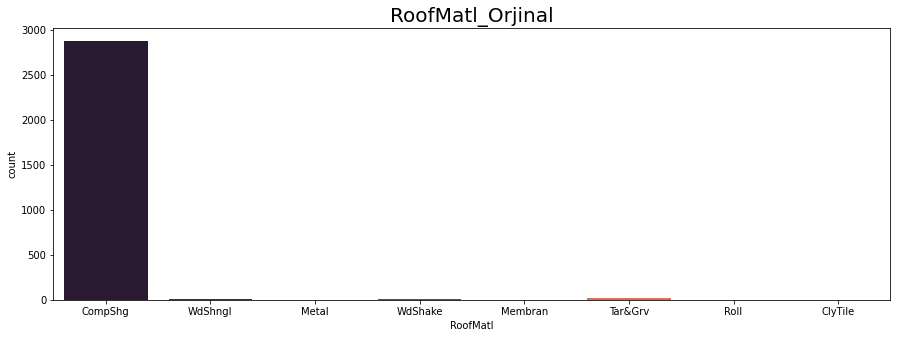

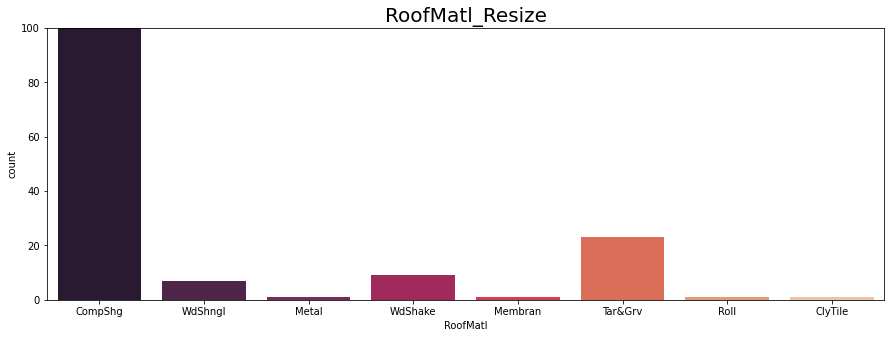

         RoofMatl      Ratio
CompShg      2876  98.526893
Tar&Grv        23   0.787941
WdShake         9   0.308325
WdShngl         7   0.239808
Metal           1   0.034258
Membran         1   0.034258
Roll            1   0.034258
ClyTile         1   0.034258


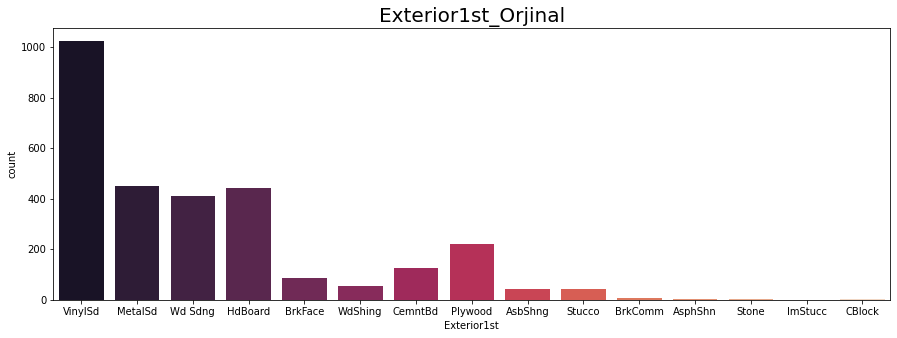

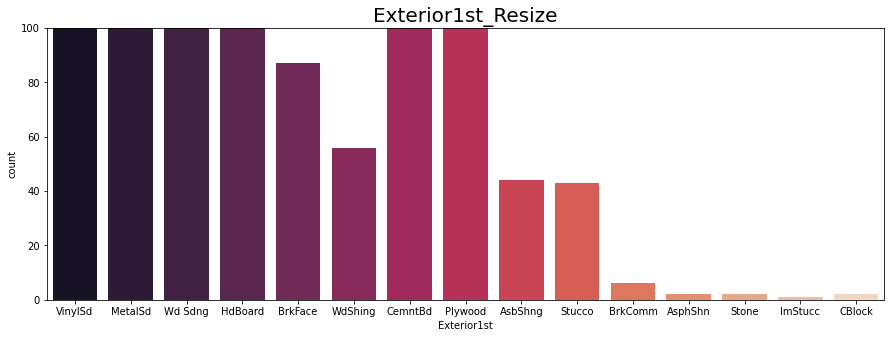

         Exterior1st      Ratio
VinylSd         1025  35.114765
MetalSd          450  15.416238
HdBoard          442  15.142172
Wd Sdng          411  14.080164
Plywood          221   7.571086
CemntBd          126   4.316547
BrkFace           87   2.980473
WdShing           56   1.918465
AsbShng           44   1.507366
Stucco            43   1.473107
BrkComm            6   0.205550
AsphShn            2   0.068517
Stone              2   0.068517
CBlock             2   0.068517
ImStucc            1   0.034258


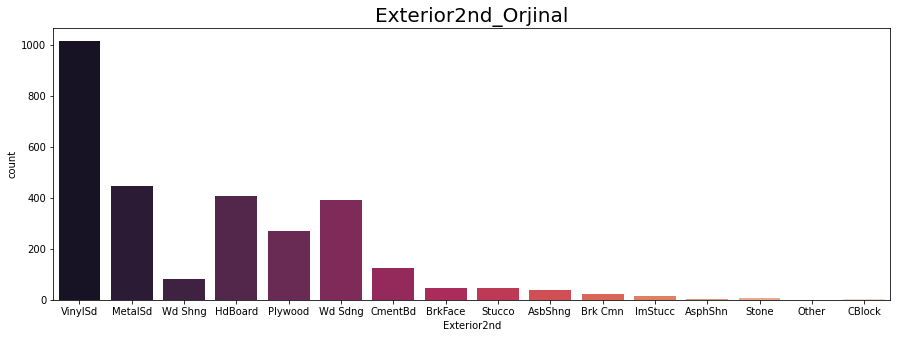

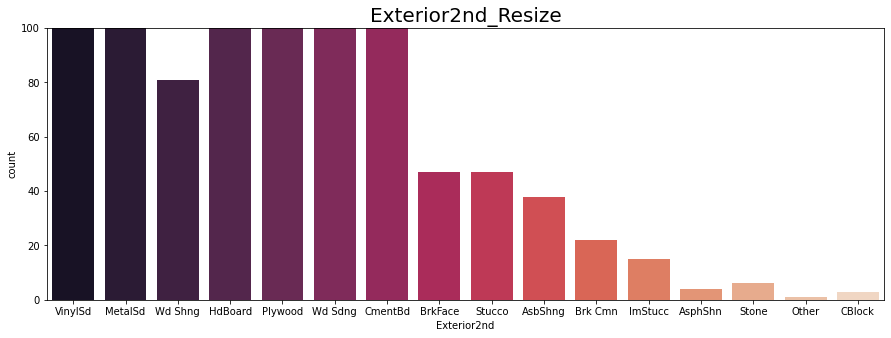

         Exterior2nd      Ratio
VinylSd         1014  34.737924
MetalSd          447  15.313464
HdBoard          406  13.908873
Wd Sdng          391  13.394998
Plywood          270   9.249743
CmentBd          126   4.316547
Wd Shng           81   2.774923
BrkFace           47   1.610140
Stucco            47   1.610140
AsbShng           38   1.301816
Brk Cmn           22   0.753683
ImStucc           15   0.513875
Stone              6   0.205550
AsphShn            4   0.137033
CBlock             3   0.102775
Other              1   0.034258


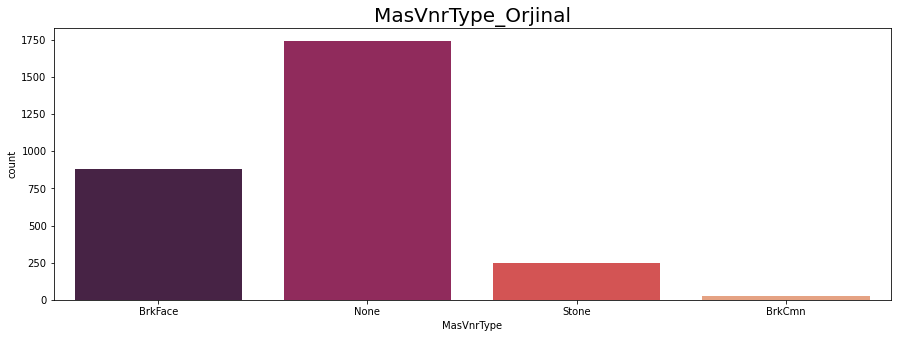

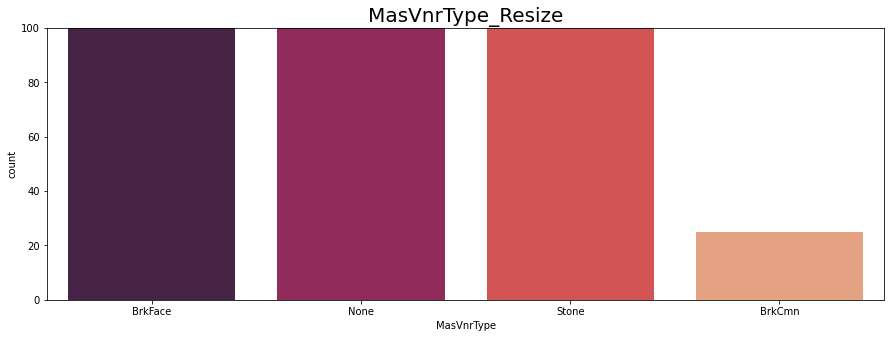

         MasVnrType      Ratio
None           1742  59.677972
BrkFace         879  30.113052
Stone           249   8.530319
BrkCmn           25   0.856458


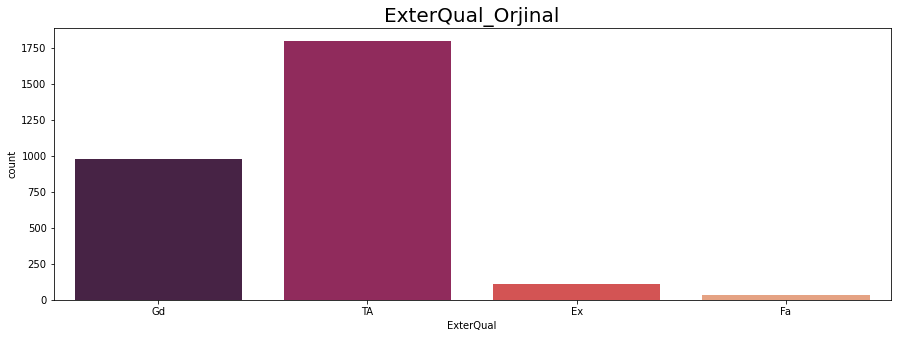

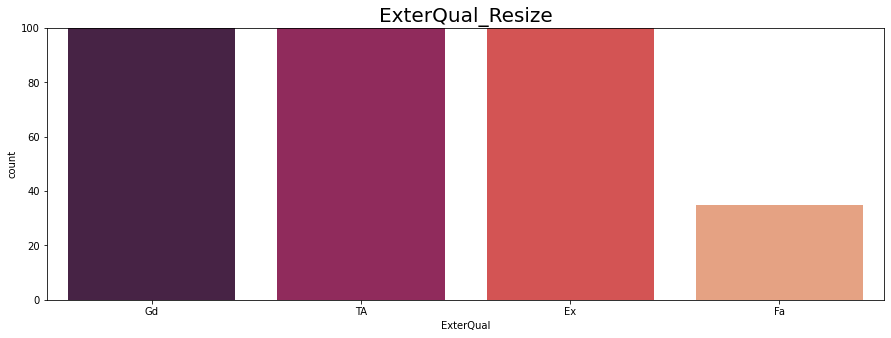

    ExterQual      Ratio
TA       1798  61.596437
Gd        979  33.538883
Ex        107   3.665639
Fa         35   1.199041


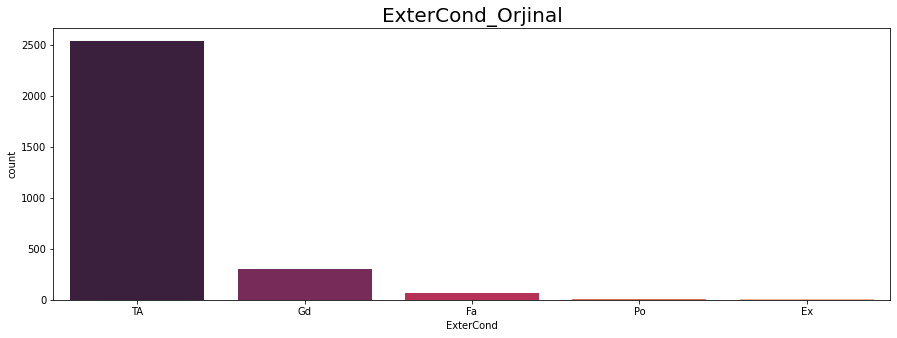

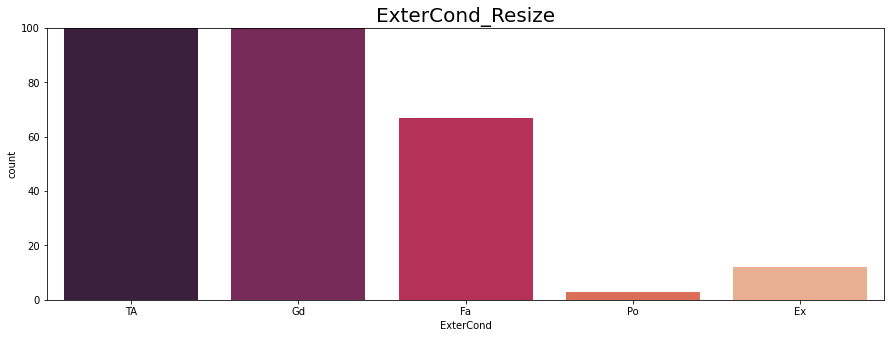

    ExterCond      Ratio
TA       2538  86.947585
Gd        299  10.243234
Fa         67   2.295307
Ex         12   0.411100
Po          3   0.102775


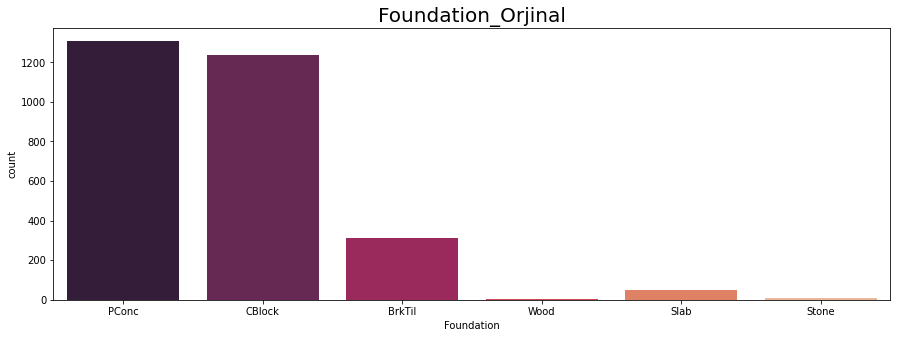

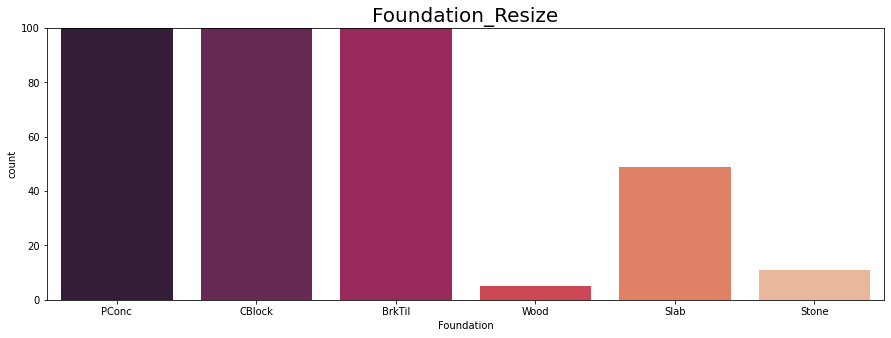

        Foundation      Ratio
PConc         1308  44.809866
CBlock        1235  42.309010
BrkTil         311  10.654334
Slab            49   1.678657
Stone           11   0.376841
Wood             5   0.171292


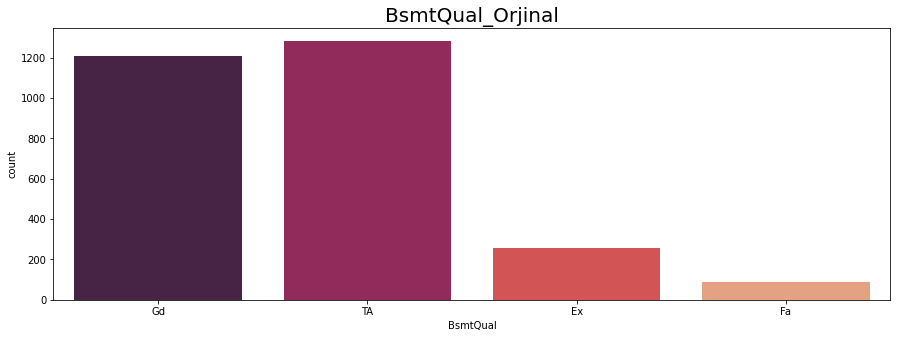

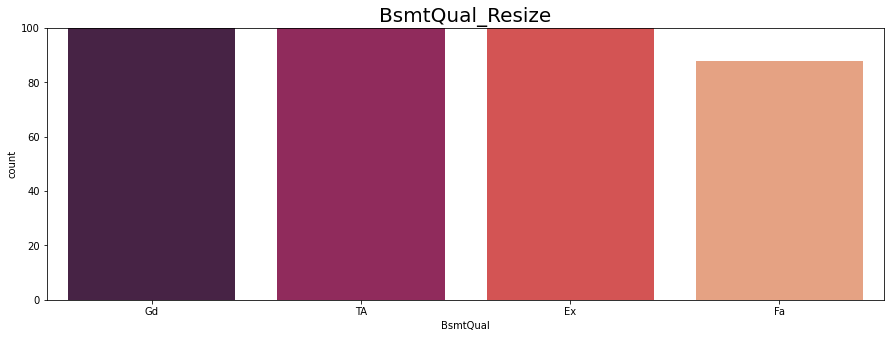

    BsmtQual      Ratio
TA      1283  43.953409
Gd      1209  41.418294
Ex       258   8.838643
Fa        88   3.014731


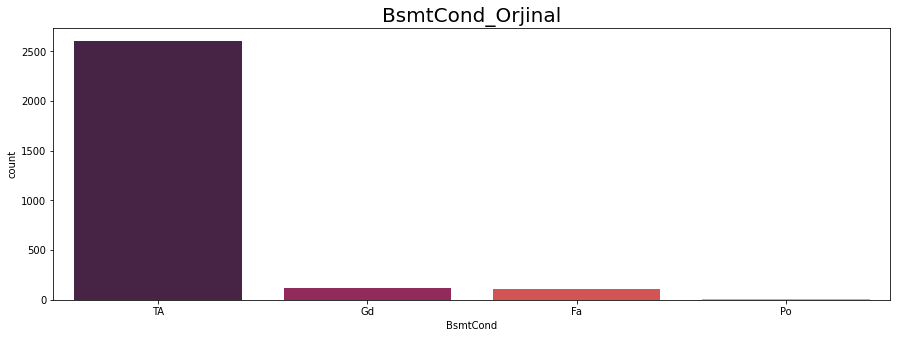

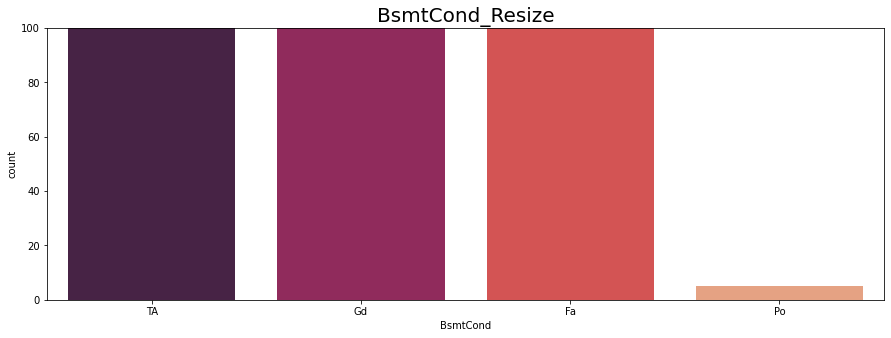

    BsmtCond      Ratio
TA      2606  89.277150
Gd       122   4.179514
Fa       104   3.562864
Po         5   0.171292


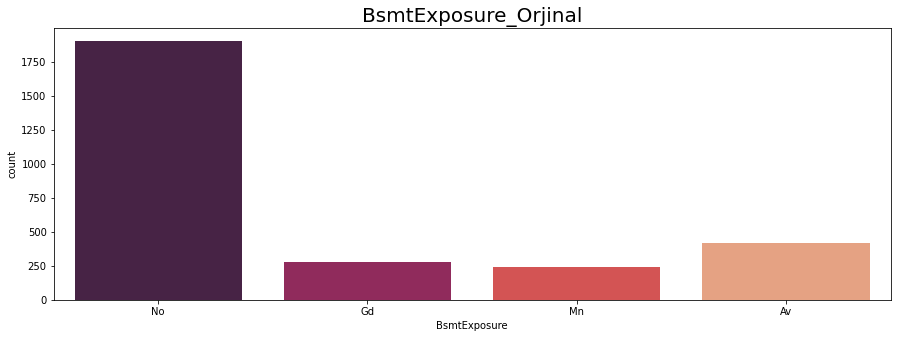

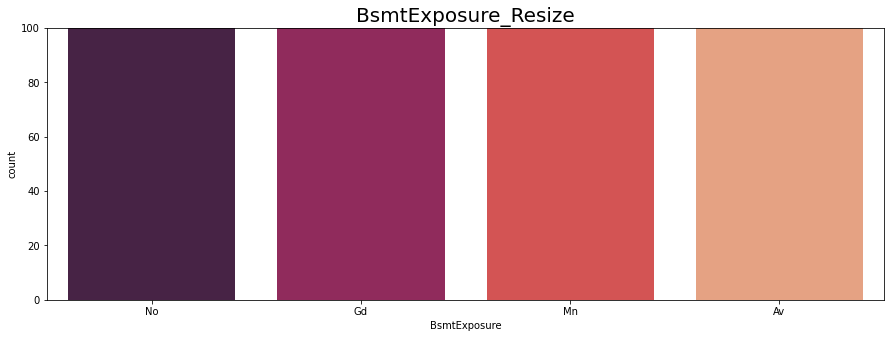

    BsmtExposure      Ratio
No          1904  65.227818
Av           418  14.319973
Gd           276   9.455293
Mn           239   8.187736


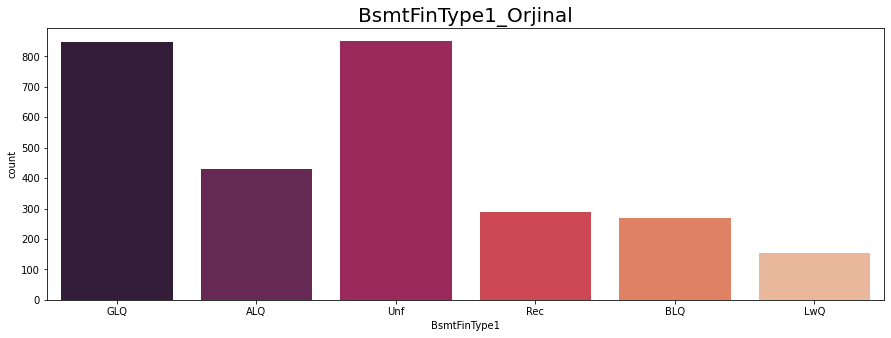

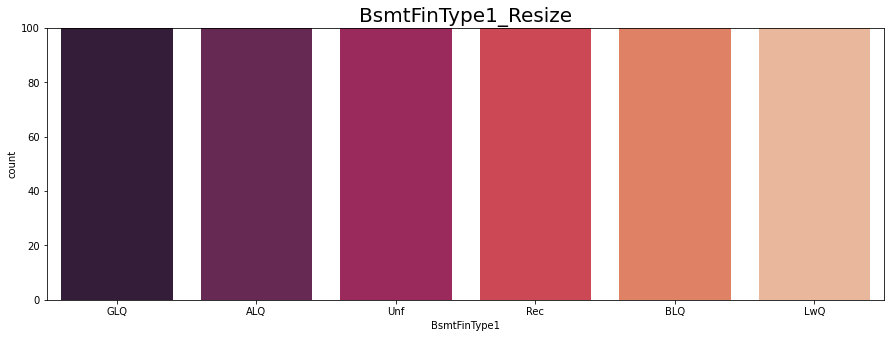

     BsmtFinType1      Ratio
Unf           851  29.153820
GLQ           849  29.085303
ALQ           429  14.696814
Rec           288   9.866393
BLQ           269   9.215485
LwQ           154   5.275779


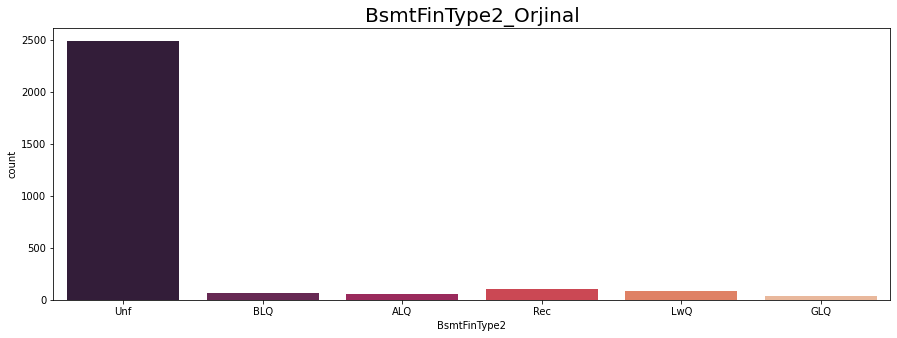

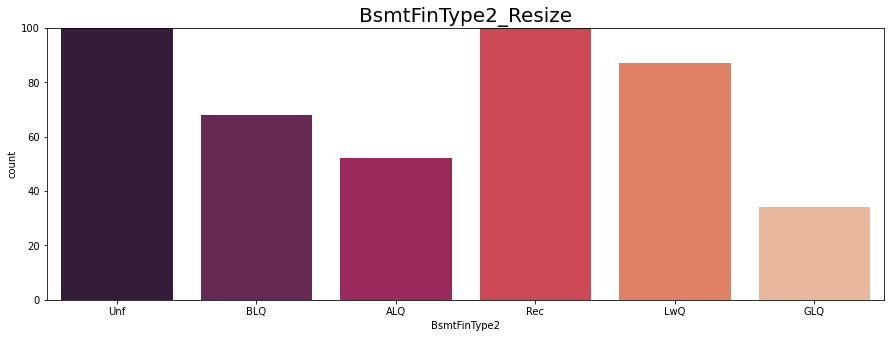

     BsmtFinType2      Ratio
Unf          2493  85.405961
Rec           105   3.597122
LwQ            87   2.980473
BLQ            68   2.329565
ALQ            52   1.781432
GLQ            34   1.164782


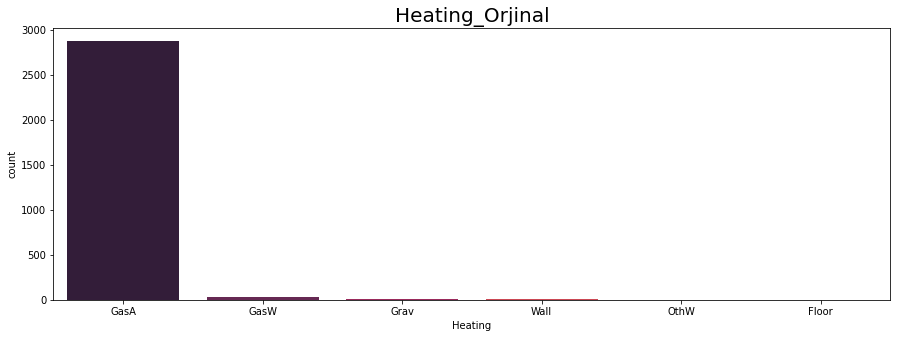

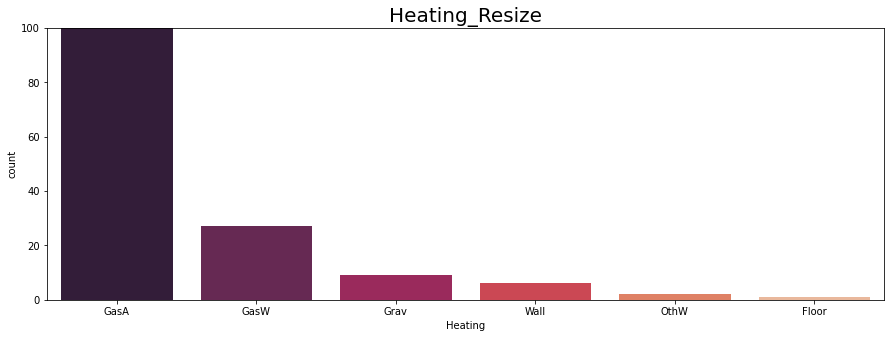

       Heating      Ratio
GasA      2874  98.458376
GasW        27   0.924974
Grav         9   0.308325
Wall         6   0.205550
OthW         2   0.068517
Floor        1   0.034258


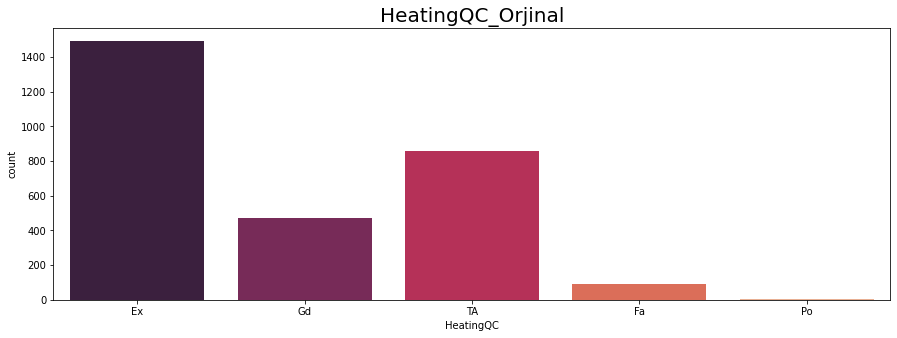

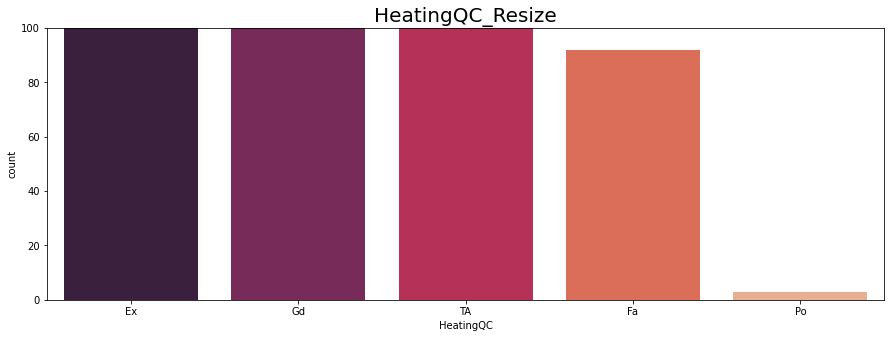

    HeatingQC      Ratio
Ex       1493  51.147653
TA        857  29.359370
Gd        474  16.238438
Fa         92   3.151764
Po          3   0.102775


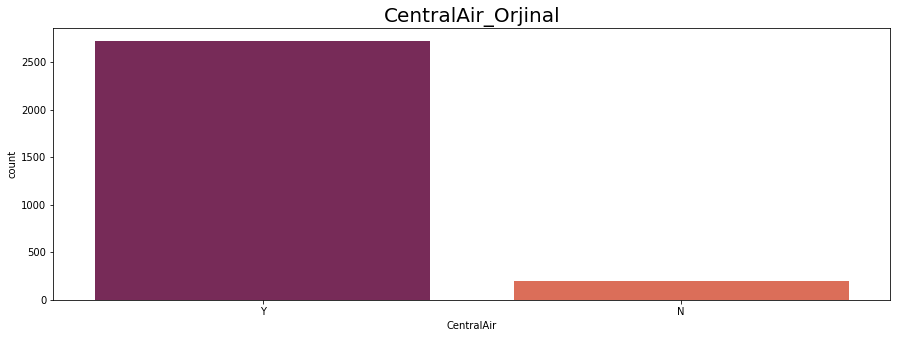

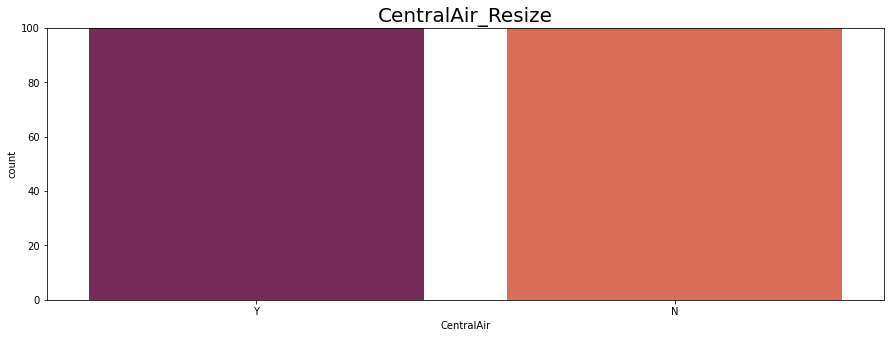

   CentralAir      Ratio
Y        2723  93.285372
N         196   6.714628


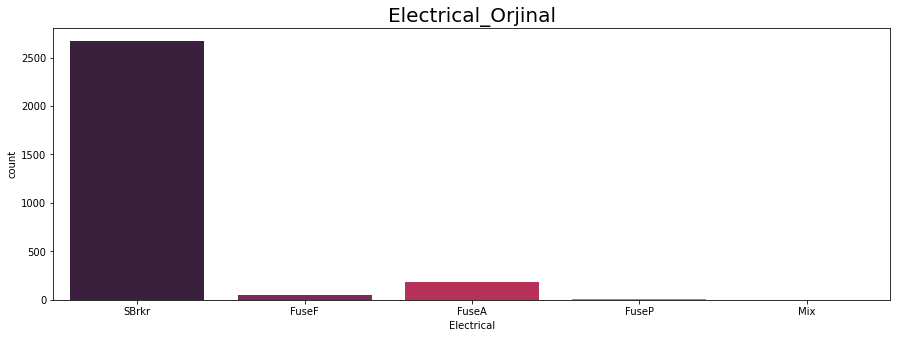

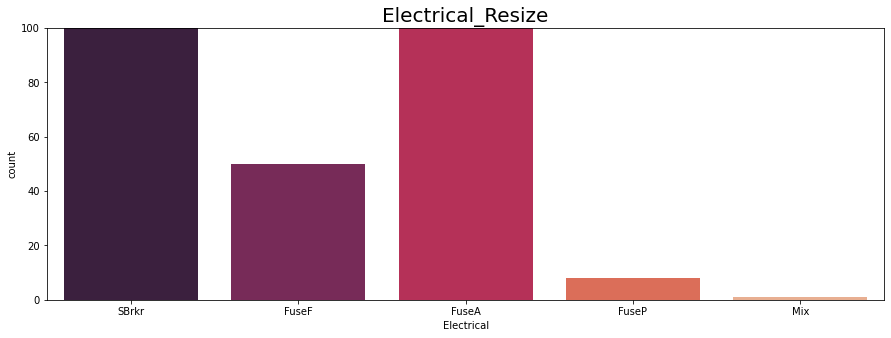

       Electrical      Ratio
SBrkr        2671  91.503940
FuseA         188   6.440562
FuseF          50   1.712915
FuseP           8   0.274066
Mix             1   0.034258


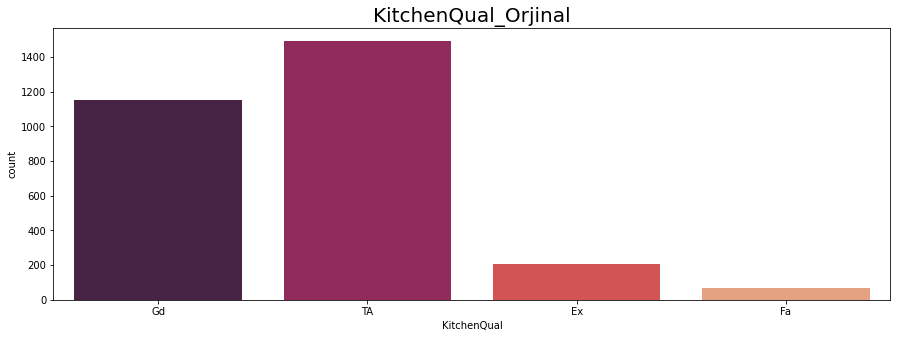

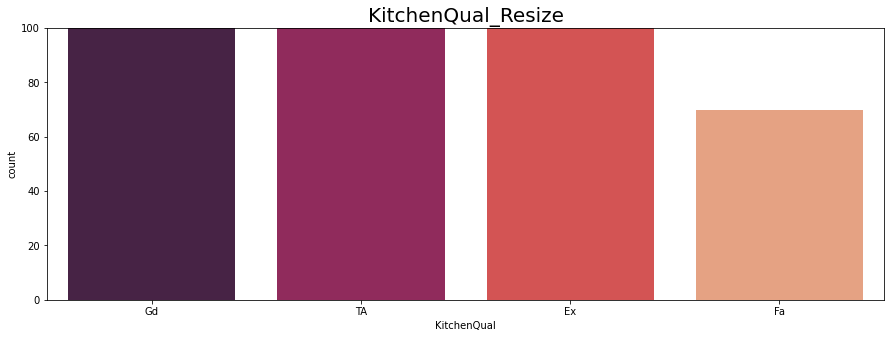

    KitchenQual      Ratio
TA         1492  51.113395
Gd         1151  39.431312
Ex          205   7.022953
Fa           70   2.398082


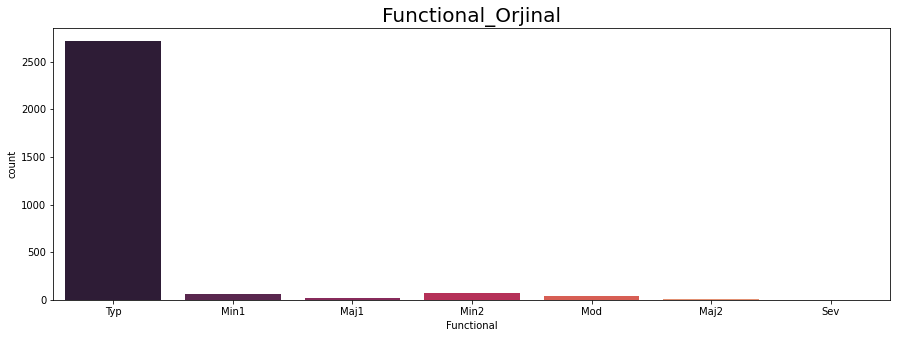

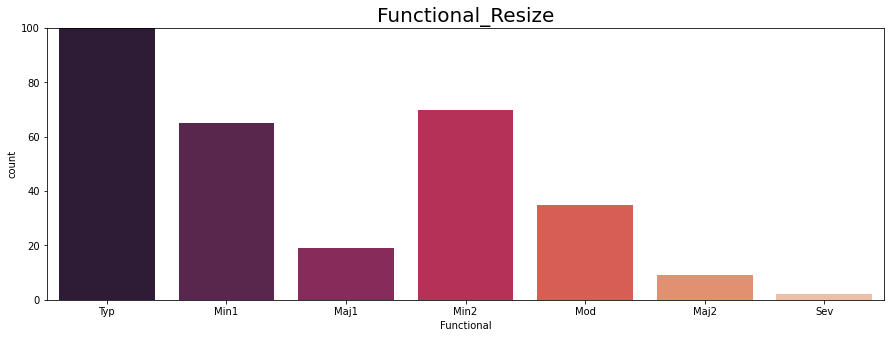

      Functional      Ratio
Typ         2717  93.079822
Min2          70   2.398082
Min1          65   2.226790
Mod           35   1.199041
Maj1          19   0.650908
Maj2           9   0.308325
Sev            2   0.068517


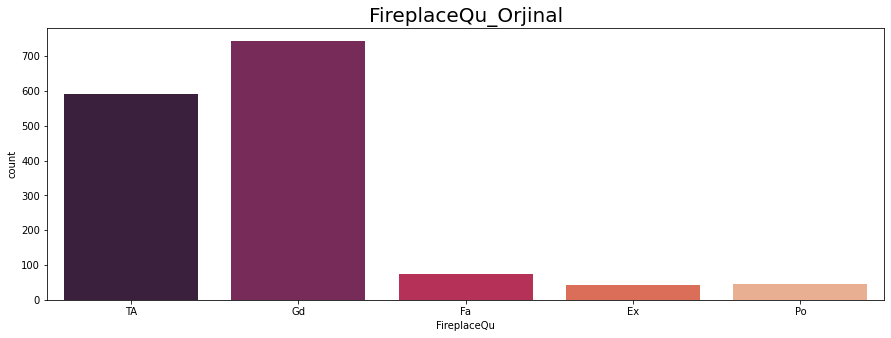

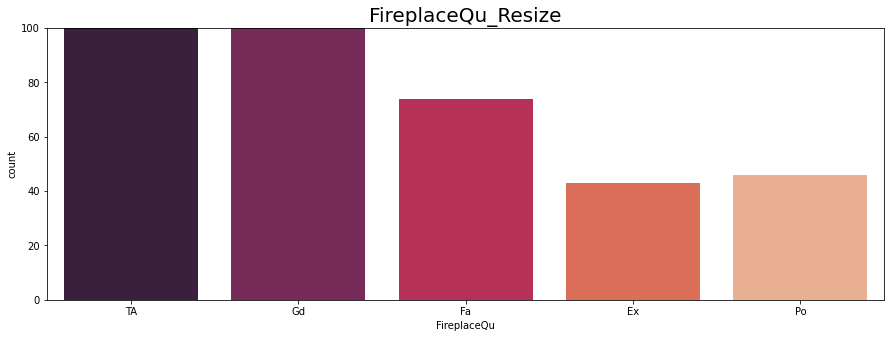

    FireplaceQu      Ratio
Gd          744  25.488181
TA          592  20.280918
Fa           74   2.535115
Po           46   1.575882
Ex           43   1.473107


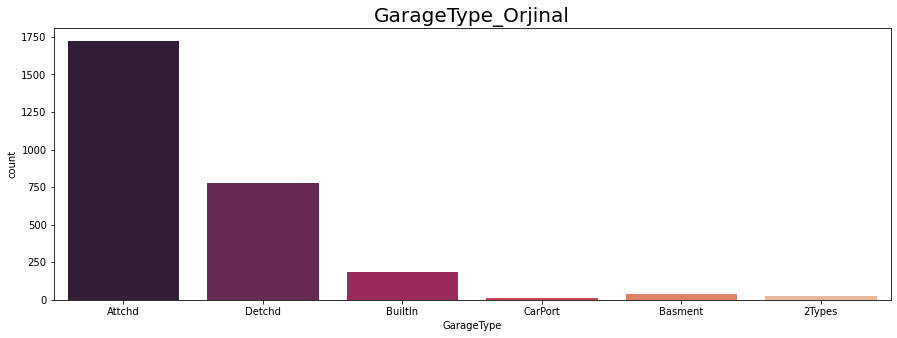

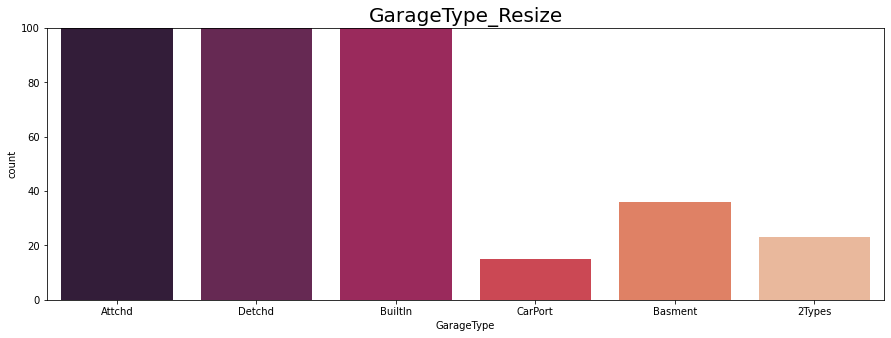

         GarageType      Ratio
Attchd         1723  59.027064
Detchd          779  26.687222
BuiltIn         186   6.372045
Basment          36   1.233299
2Types           23   0.787941
CarPort          15   0.513875


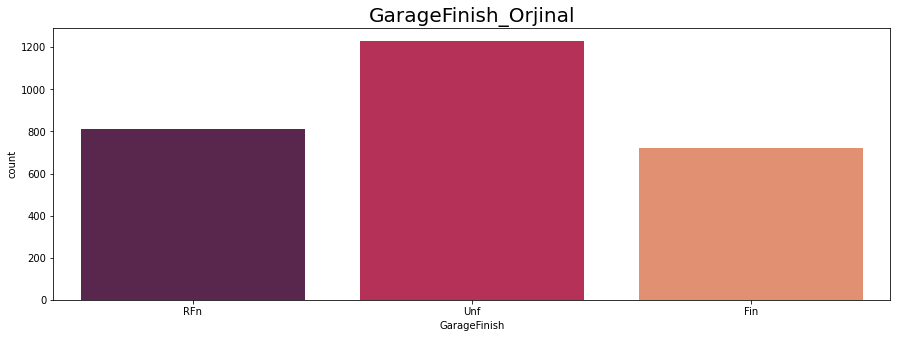

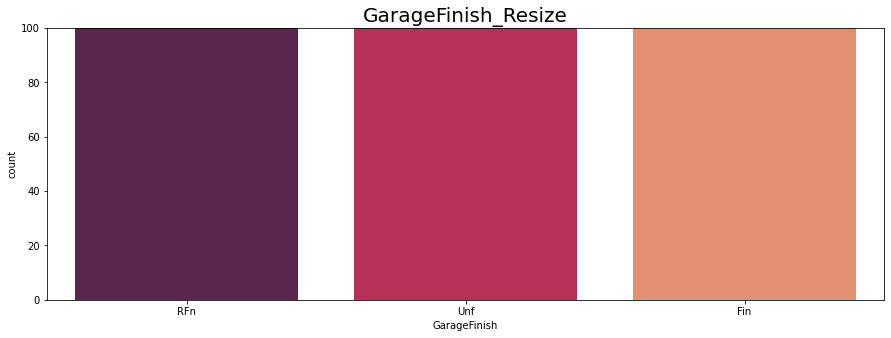

     GarageFinish      Ratio
Unf          1230  42.137718
RFn           811  27.783487
Fin           719  24.631723


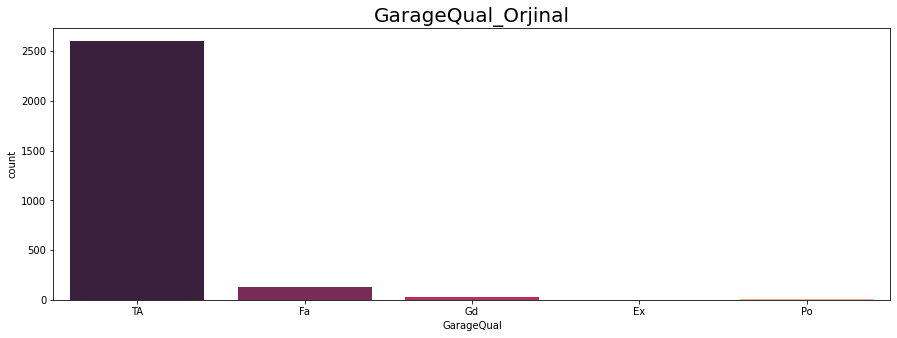

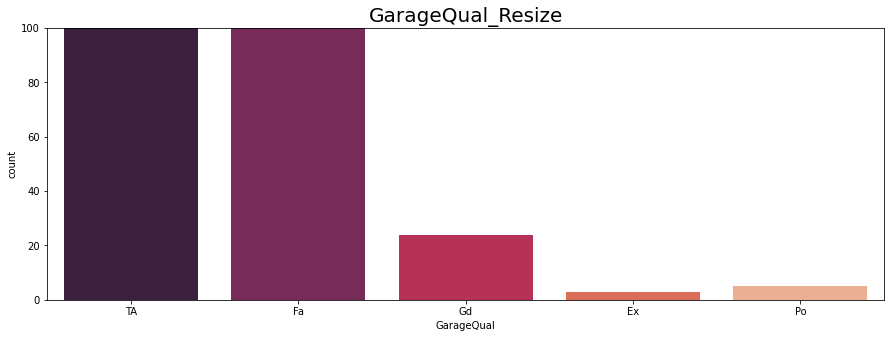

    GarageQual      Ratio
TA        2604  89.208633
Fa         124   4.248030
Gd          24   0.822199
Po           5   0.171292
Ex           3   0.102775


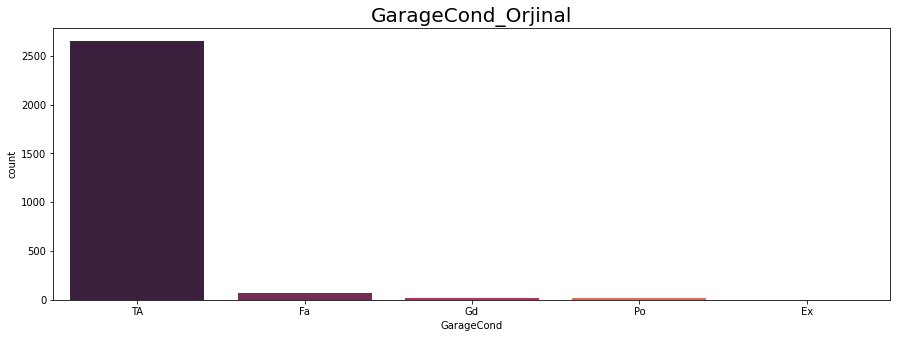

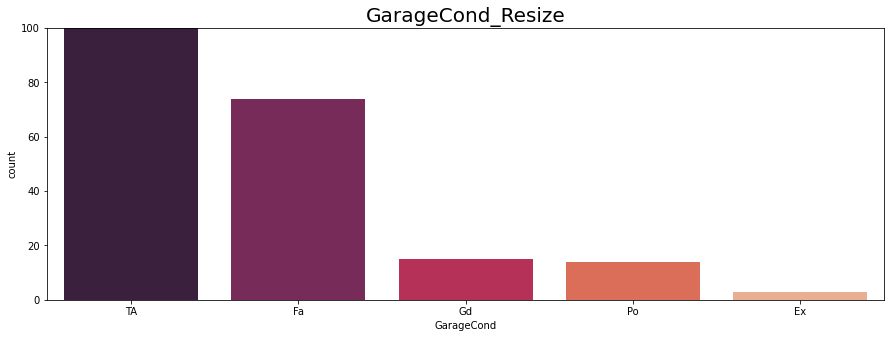

    GarageCond      Ratio
TA        2654  90.921548
Fa          74   2.535115
Gd          15   0.513875
Po          14   0.479616
Ex           3   0.102775


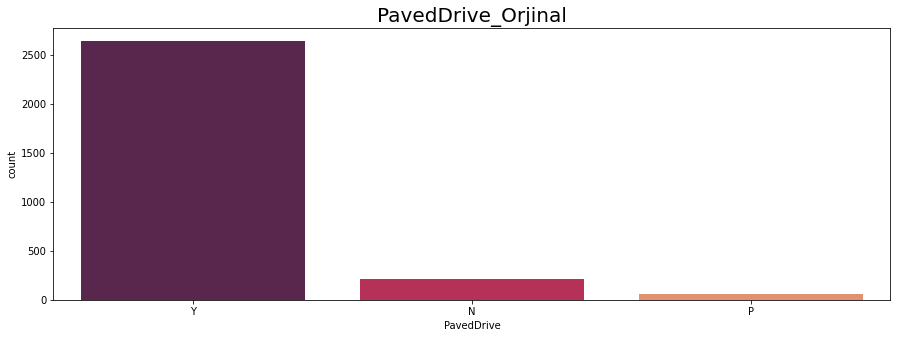

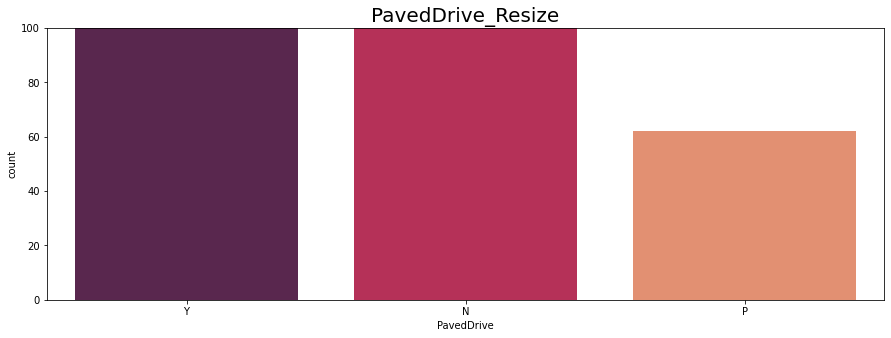

   PavedDrive      Ratio
Y        2641  90.476190
N         216   7.399794
P          62   2.124015


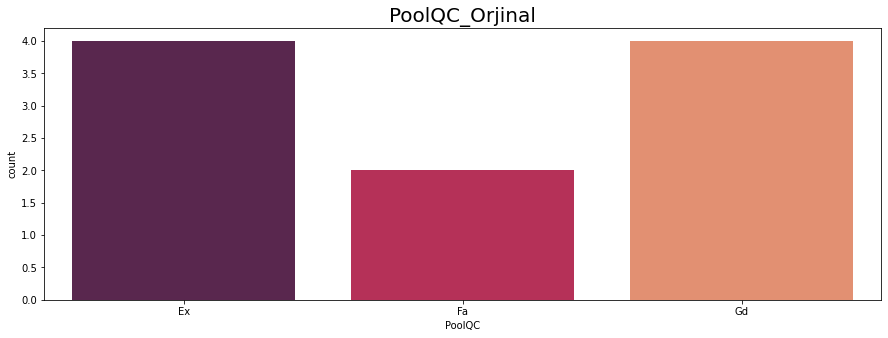

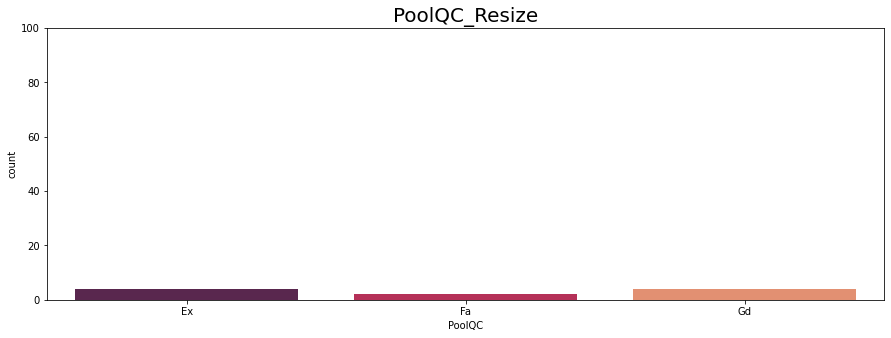

    PoolQC     Ratio
Ex       4  0.137033
Gd       4  0.137033
Fa       2  0.068517


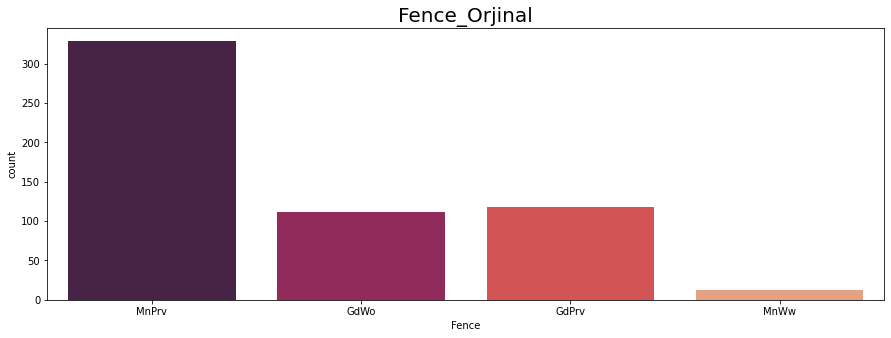

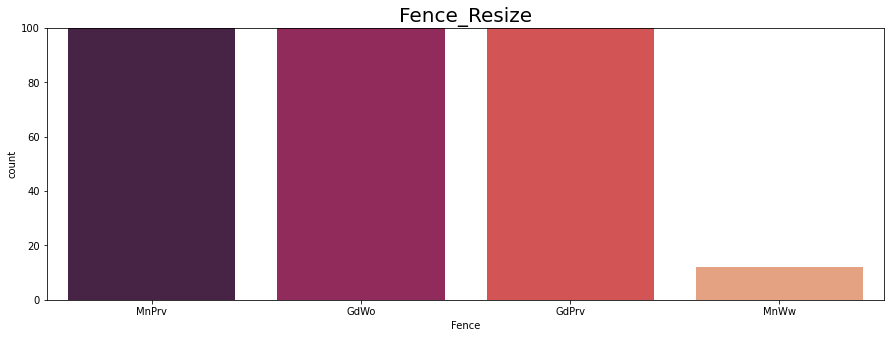

       Fence      Ratio
MnPrv    329  11.270983
GdPrv    118   4.042480
GdWo     112   3.836930
MnWw      12   0.411100


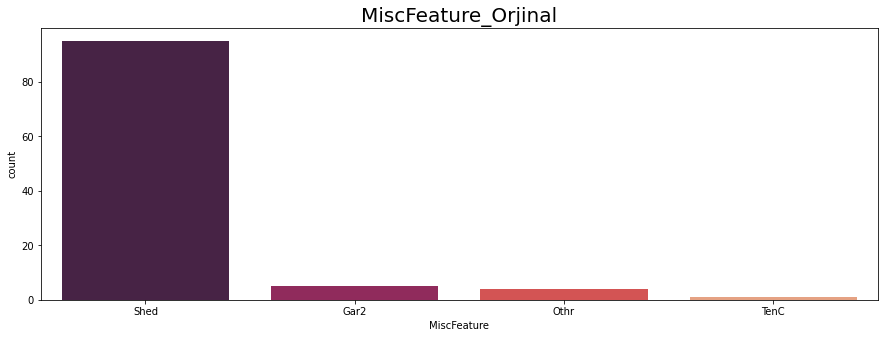

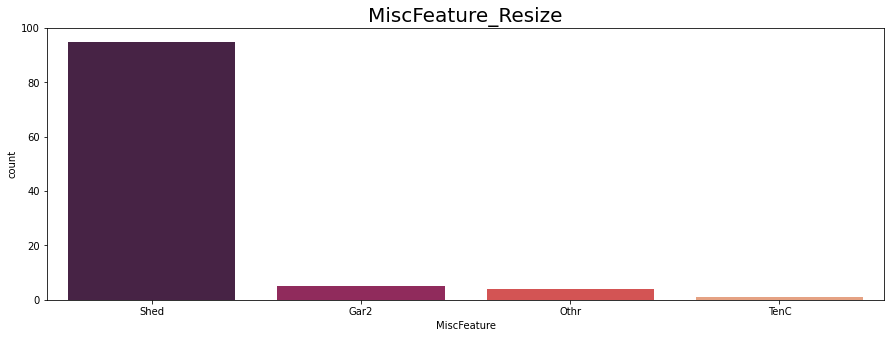

      MiscFeature     Ratio
Shed           95  3.254539
Gar2            5  0.171292
Othr            4  0.137033
TenC            1  0.034258


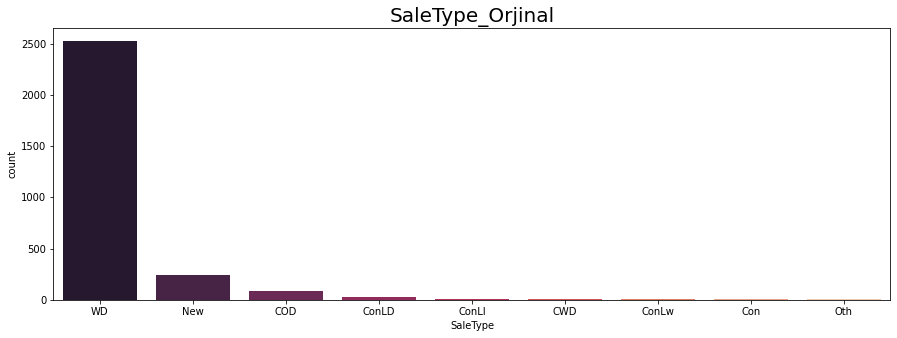

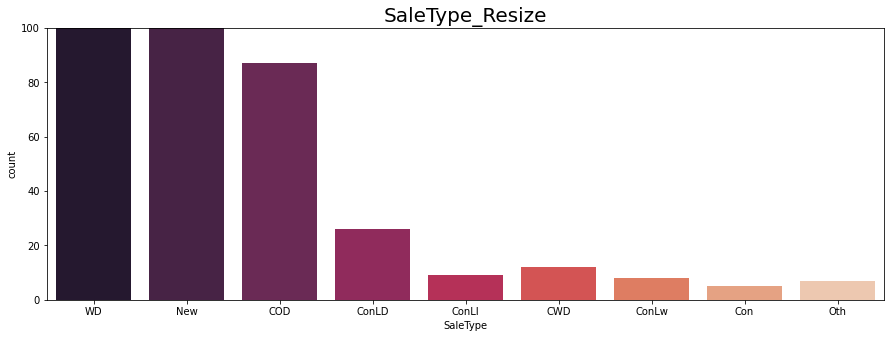

       SaleType      Ratio
WD         2525  86.502227
New         239   8.187736
COD          87   2.980473
ConLD        26   0.890716
CWD          12   0.411100
ConLI         9   0.308325
ConLw         8   0.274066
Oth           7   0.239808
Con           5   0.171292


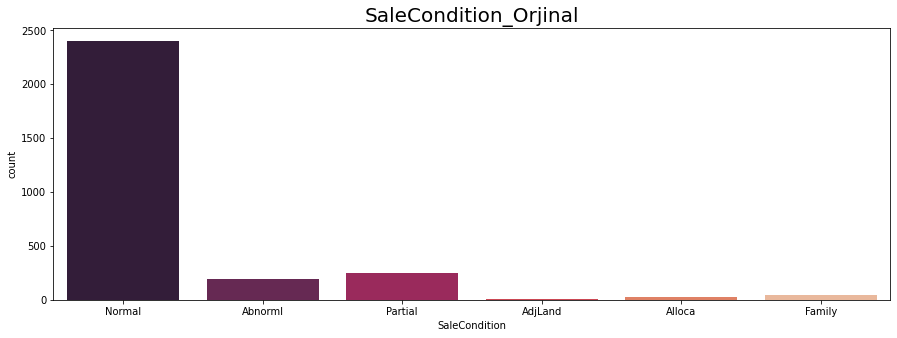

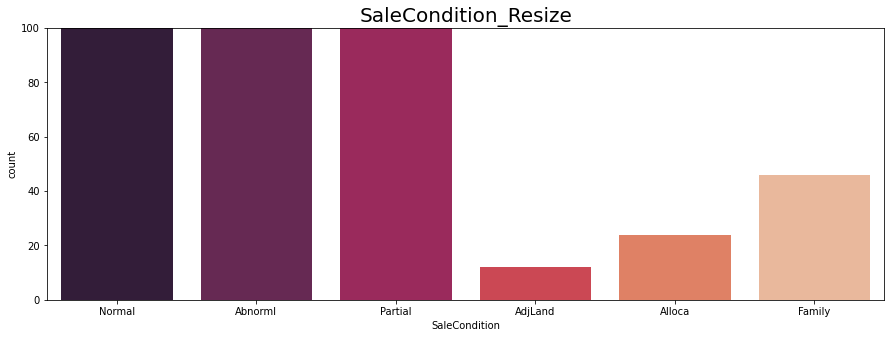

         SaleCondition      Ratio
Normal            2402  82.288455
Partial            245   8.393285
Abnorml            190   6.509078
Family              46   1.575882
Alloca              24   0.822199
AdjLand             12   0.411100


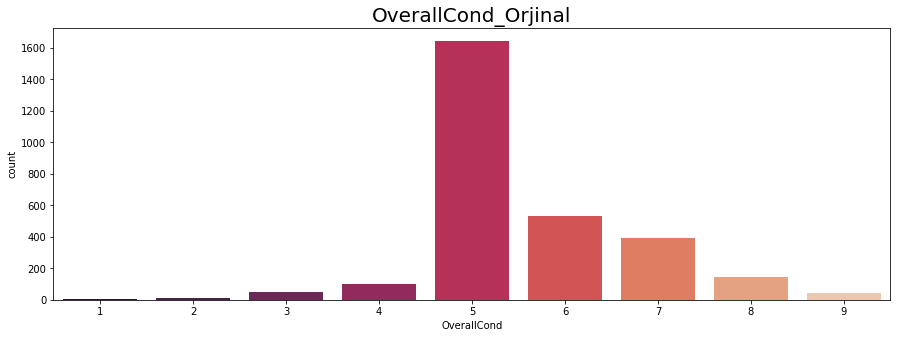

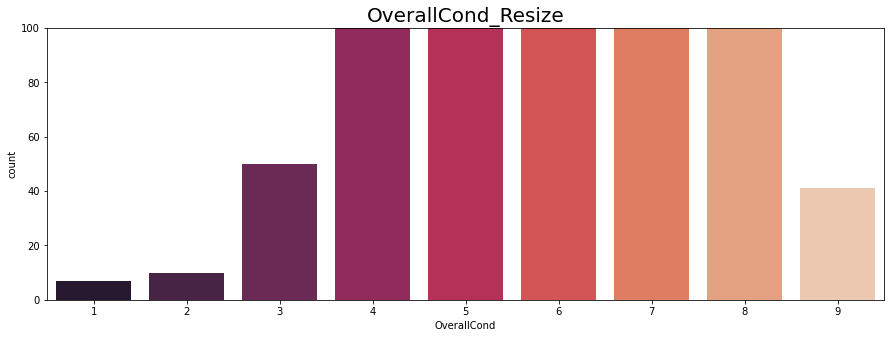

   OverallCond      Ratio
5         1645  56.354916
6          531  18.191161
7          390  13.360740
8          144   4.933196
4          101   3.460089
3           50   1.712915
9           41   1.404591
2           10   0.342583
1            7   0.239808


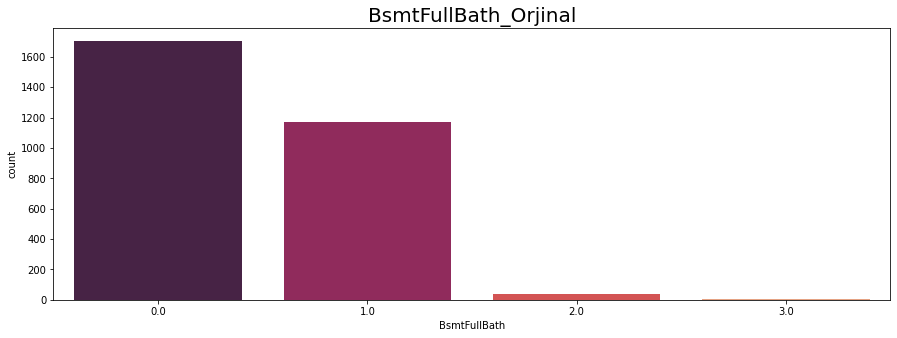

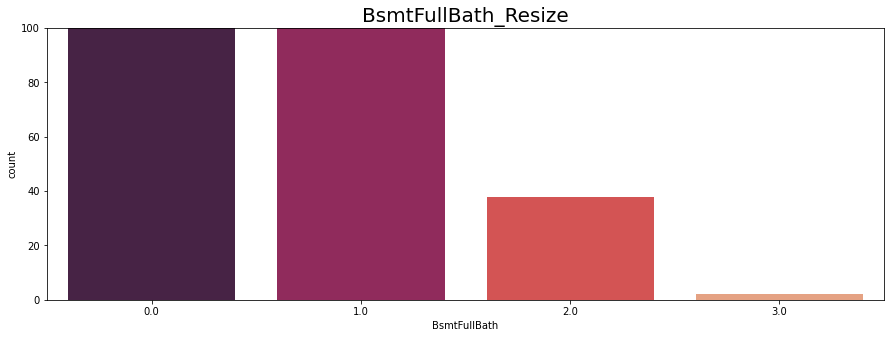

     BsmtFullBath      Ratio
0.0          1705  58.410415
1.0          1172  40.150737
2.0            38   1.301816
3.0             2   0.068517


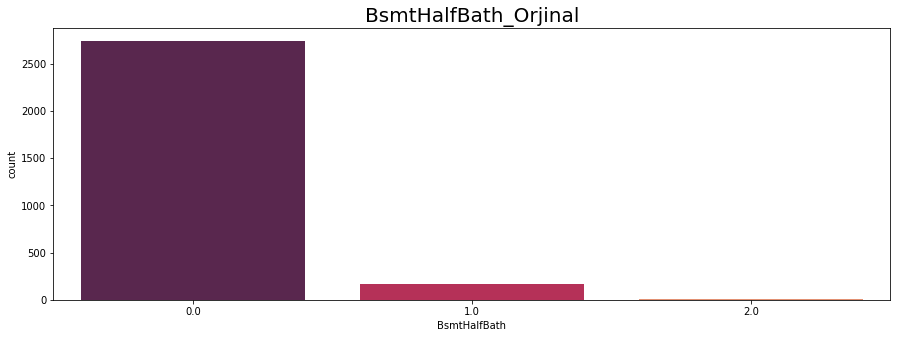

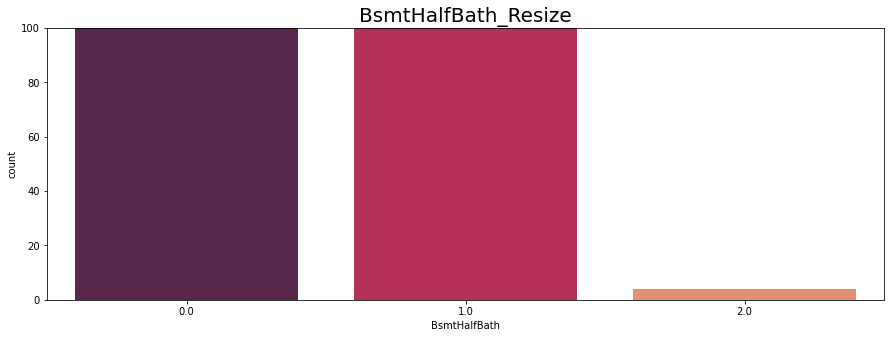

     BsmtHalfBath      Ratio
0.0          2742  93.936280
1.0           171   5.858171
2.0             4   0.137033


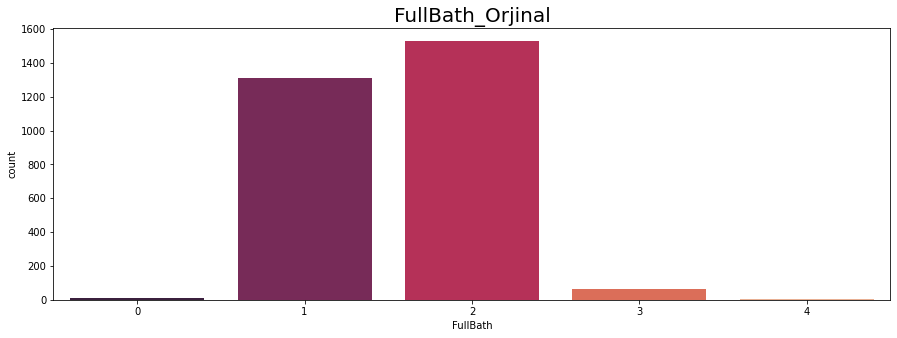

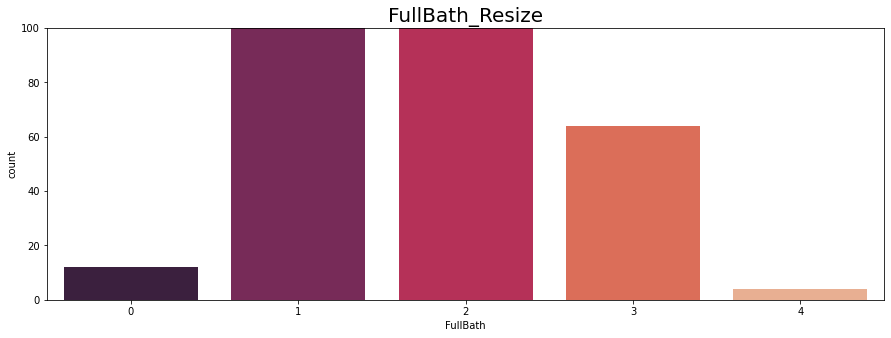

   FullBath      Ratio
2      1530  52.415211
1      1309  44.844125
3        64   2.192532
0        12   0.411100
4         4   0.137033


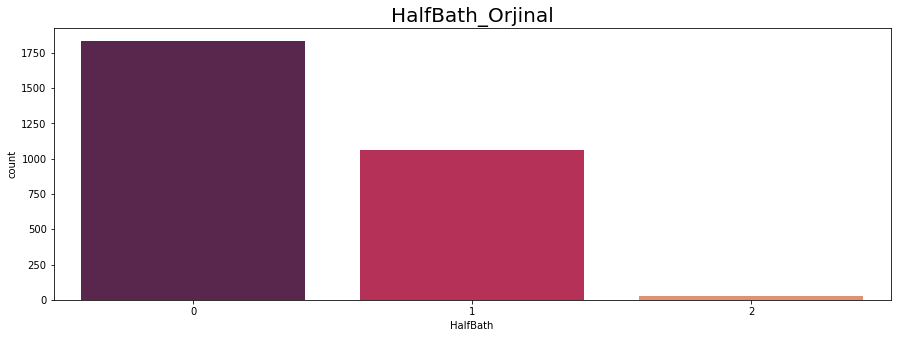

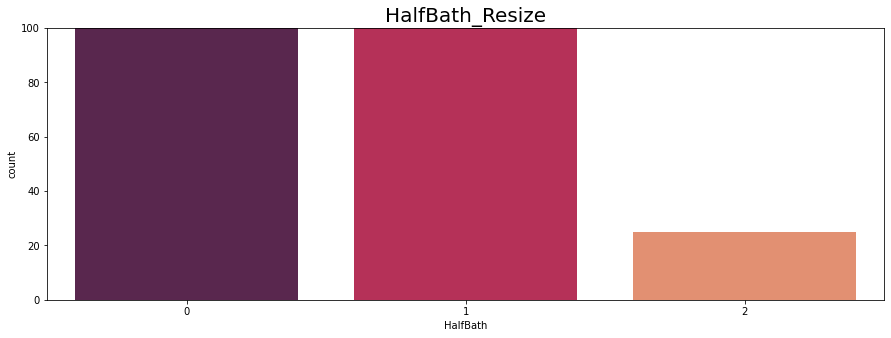

   HalfBath      Ratio
0      1834  62.829736
1      1060  36.313806
2        25   0.856458


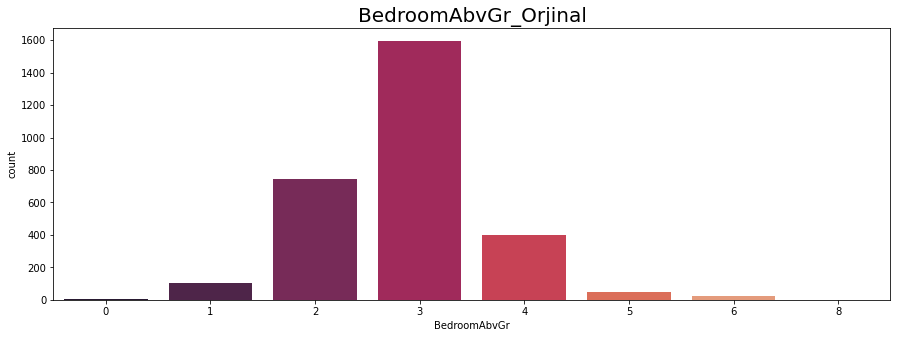

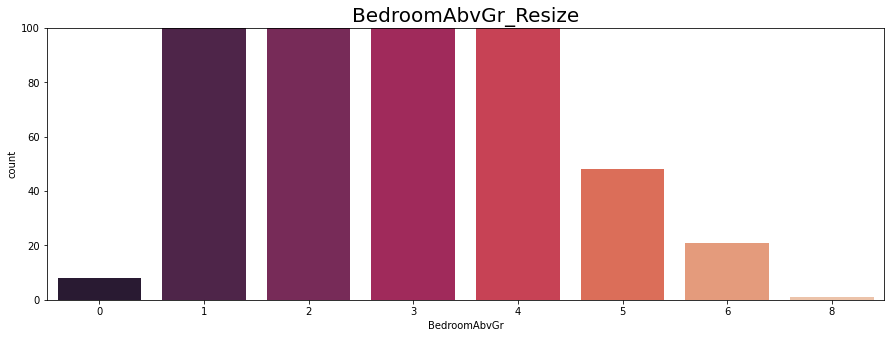

   BedroomAbvGr      Ratio
3          1596  54.676259
2           742  25.419664
4           400  13.703323
1           103   3.528606
5            48   1.644399
6            21   0.719424
0             8   0.274066
8             1   0.034258


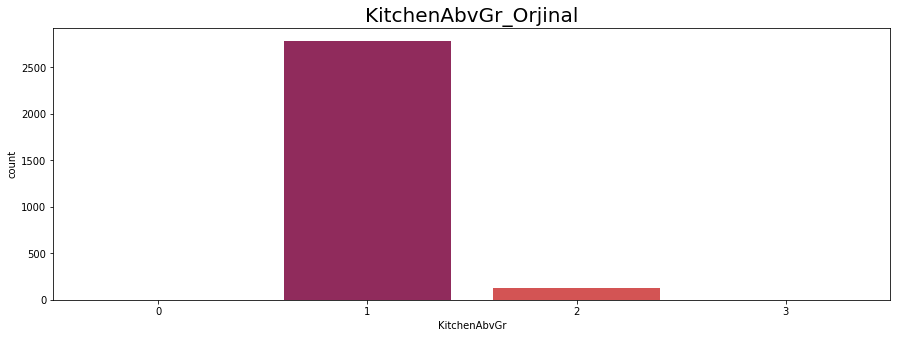

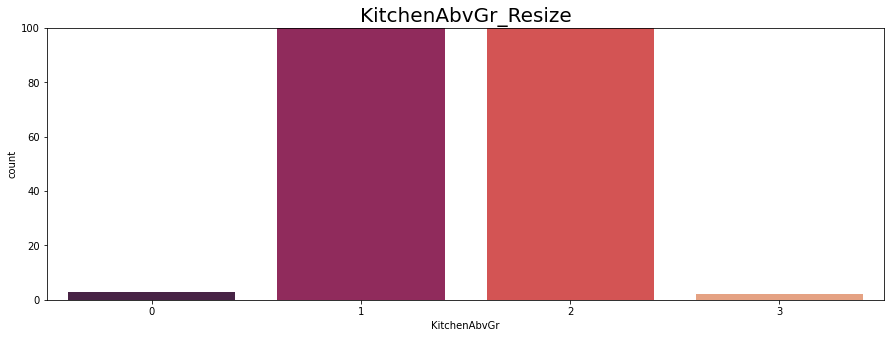

   KitchenAbvGr      Ratio
1          2785  95.409387
2           129   4.419322
0             3   0.102775
3             2   0.068517


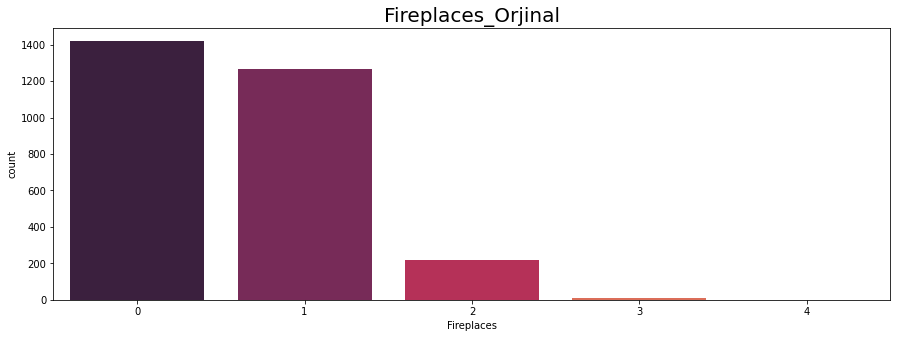

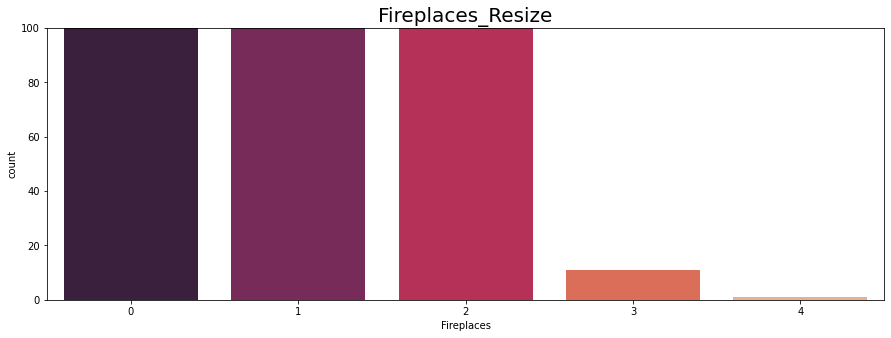

   Fireplaces      Ratio
0        1420  48.646797
1        1268  43.439534
2         219   7.502569
3          11   0.376841
4           1   0.034258


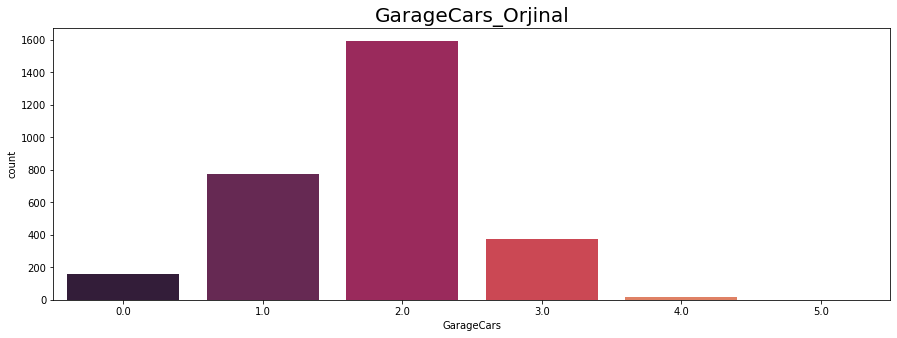

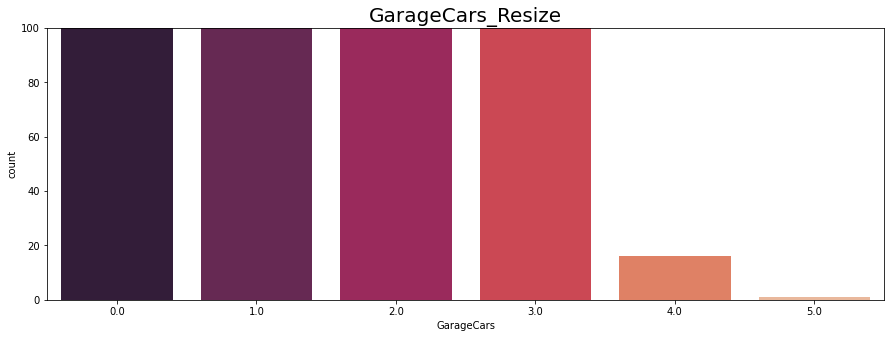

     GarageCars      Ratio
2.0        1594  54.607742
1.0         776  26.584447
3.0         374  12.812607
0.0         157   5.378554
4.0          16   0.548133
5.0           1   0.034258


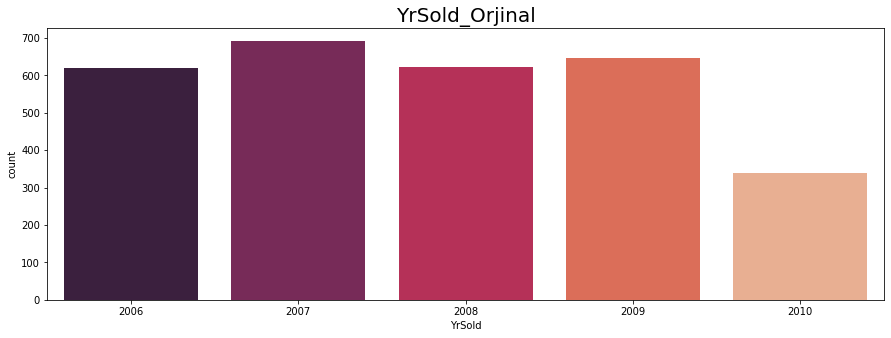

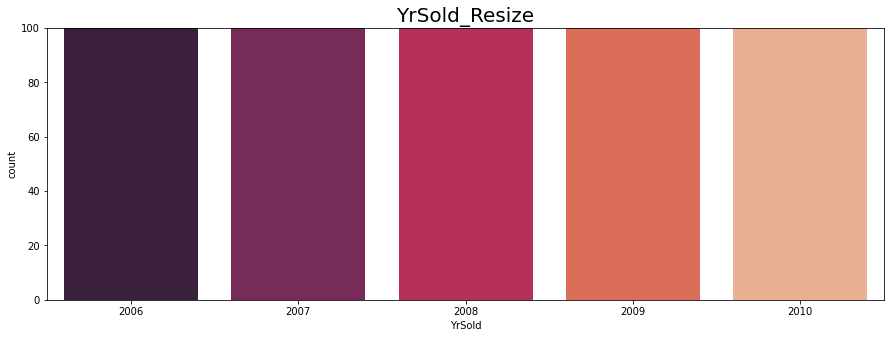

      YrSold      Ratio
2007     692  23.706749
2009     647  22.165125
2008     622  21.308667
2006     619  21.205892
2010     339  11.613566


In [20]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

<center> <h1 style="background-color:red; color:white" >Numerical Columns</h1><center>

In [21]:
df[num_cols].describe([0.05, 0.1, 0.25, 0.5, 0.75, 0.95, 0.99]).T

,count,mean,std,min,5%,10%,25%,50%,75%,95%,99%,max
Id,2919.0,1460.000000,842.787043,1.0,146.90,292.8,730.5,1460.0,2189.5,2773.10,2889.82,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.00,20.0,20.0,50.0,70.0,160.00,190.00,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,32.00,43.0,59.0,68.0,80.0,107.00,135.68,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,3182.00,4922.4,7478.0,9453.0,11570.0,17142.90,33038.64,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,4.00,5.0,5.0,6.0,7.0,8.00,10.00,10.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1915.00,1924.0,1953.5,1973.0,2001.0,2007.00,2008.00,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1950.00,1950.0,1965.0,1993.0,2004.0,2007.00,2009.00,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.00,0.0,0.0,0.0,164.0,466.50,771.05,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.00,0.0,0.0,368.5,733.0,1274.00,1635.32,5644.0
BsmtFinSF2,2918.0,49.582248,169.205611,0.0,0.00,0.0,0.0,0.0,0.0,435.00,874.66,1526.0


In [22]:
num_cols.remove("Id")

In [23]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.20, 0.40, 0.60, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        
        plt.figure(figsize=(12,4)),
        plt.subplot(2,1,1)  
        dataframe[numerical_col].hist(bins=30, stacked=True, histtype='barstacked',color='darkred')
        plt.xlabel(numerical_col)
        plt.title(numerical_col + "_Orjinal",fontsize=20)
        
        plt.figure(figsize=(12,4))
        plt.subplot(2,1,2)
        dataframe[numerical_col].hist(bins=30, stacked=True, histtype='barstacked',color='red')
        plt.ylim([0,100])
        plt.title(numerical_col + "_Resize",fontsize=20)
        plt.xlabel(numerical_col)
        
        
        plt.show()

count    2919.000000
mean       57.137718
std        42.517628
min        20.000000
5%         20.000000
20%        20.000000
40%        30.000000
50%        50.000000
60%        60.000000
80%        80.000000
90%       120.000000
95%       160.000000
99%       190.000000
max       190.000000
Name: MSSubClass, dtype: float64


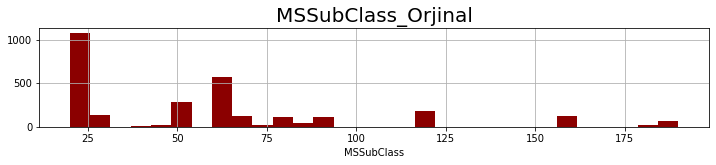

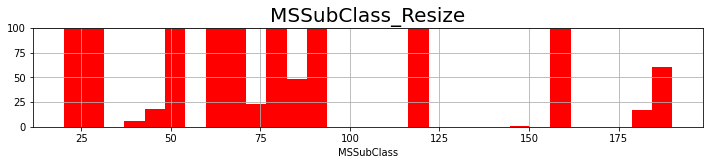

count    2433.000000
mean       69.305795
std        23.344905
min        21.000000
5%         32.000000
20%        53.000000
40%        63.000000
50%        68.000000
60%        73.000000
80%        84.000000
90%        95.000000
95%       107.000000
99%       135.680000
max       313.000000
Name: LotFrontage, dtype: float64


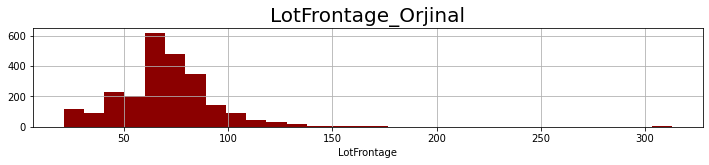

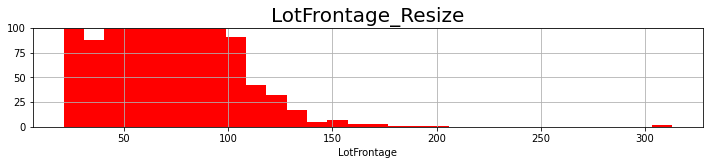

count      2919.000000
mean      10168.114080
std        7886.996359
min        1300.000000
5%         3182.000000
20%        7007.600000
40%        8741.000000
50%        9453.000000
60%       10151.600000
80%       12203.800000
90%       14300.600000
95%       17142.900000
99%       33038.640000
max      215245.000000
Name: LotArea, dtype: float64


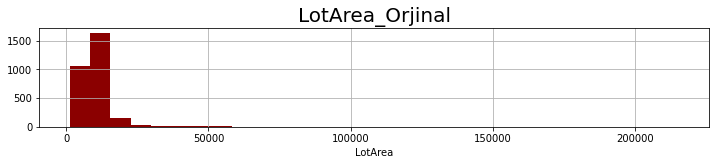

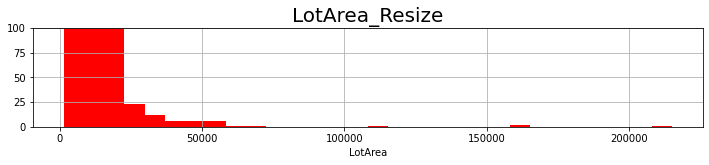

count    2919.000000
mean        6.089072
std         1.409947
min         1.000000
5%          4.000000
20%         5.000000
40%         6.000000
50%         6.000000
60%         6.000000
80%         7.000000
90%         8.000000
95%         8.000000
99%        10.000000
max        10.000000
Name: OverallQual, dtype: float64


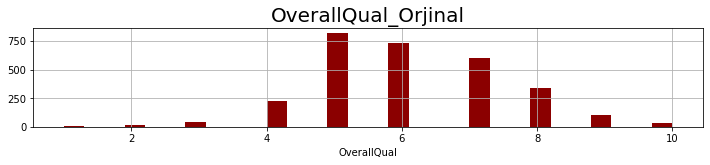

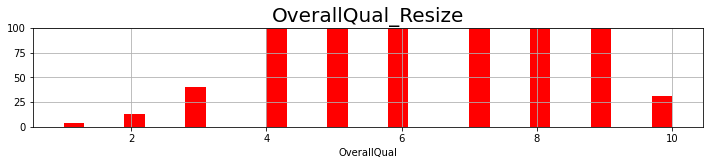

count    2919.000000
mean     1971.312778
std        30.291442
min      1872.000000
5%       1915.000000
20%      1947.000000
40%      1965.000000
50%      1973.000000
60%      1984.000000
80%      2003.000000
90%      2006.000000
95%      2007.000000
99%      2008.000000
max      2010.000000
Name: YearBuilt, dtype: float64


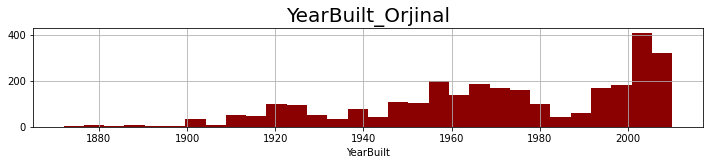

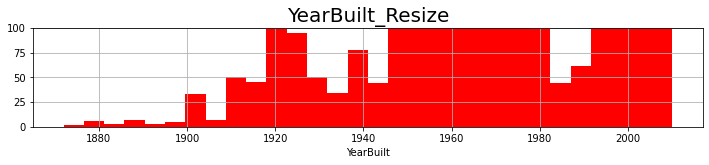

count    2919.000000
mean     1984.264474
std        20.894344
min      1950.000000
5%       1950.000000
20%      1960.000000
40%      1978.000000
50%      1993.000000
60%      1998.000000
80%      2005.000000
90%      2006.200000
95%      2007.000000
99%      2009.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


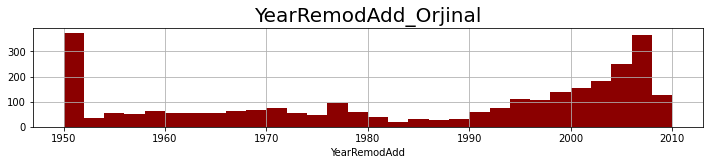

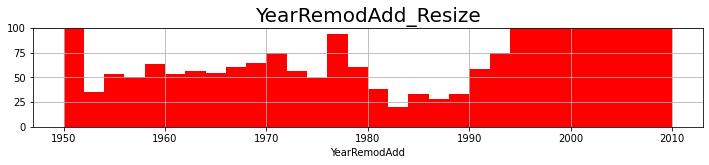

count    2896.000000
mean      102.201312
std       179.334253
min         0.000000
5%          0.000000
20%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
80%       202.000000
90%       325.500000
95%       466.500000
99%       771.050000
max      1600.000000
Name: MasVnrArea, dtype: float64


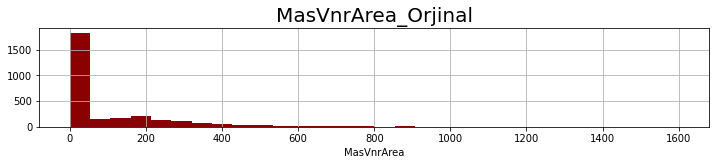

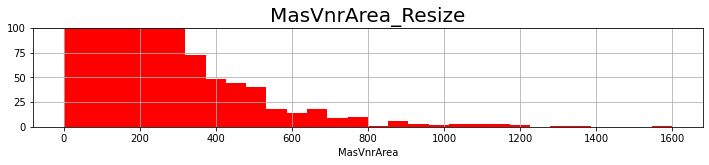

count    2918.000000
mean      441.423235
std       455.610826
min         0.000000
5%          0.000000
20%         0.000000
40%       202.600000
50%       368.500000
60%       515.200000
80%       812.000000
90%      1056.900000
95%      1274.000000
99%      1635.320000
max      5644.000000
Name: BsmtFinSF1, dtype: float64


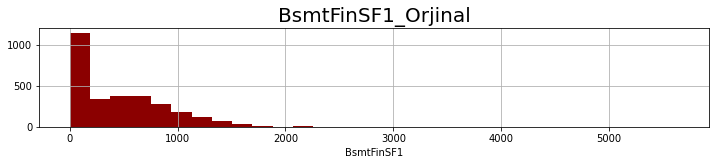

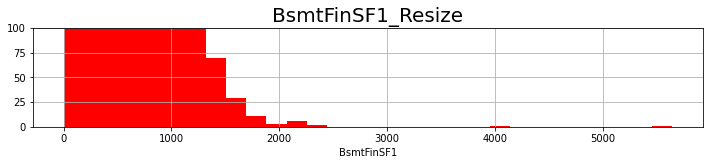

count    2918.000000
mean       49.582248
std       169.205611
min         0.000000
5%          0.000000
20%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
80%         0.000000
90%       125.600000
95%       435.000000
99%       874.660000
max      1526.000000
Name: BsmtFinSF2, dtype: float64


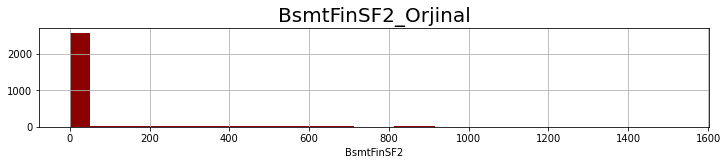

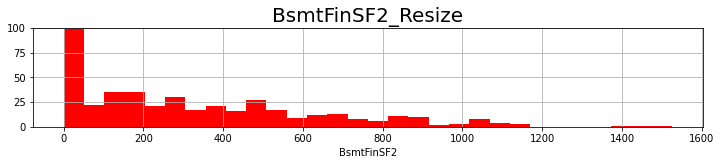

count    2918.000000
mean      560.772104
std       439.543659
min         0.000000
5%          0.000000
20%       174.000000
40%       365.800000
50%       467.000000
60%       595.000000
80%       892.600000
90%      1212.600000
95%      1474.900000
99%      1776.490000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


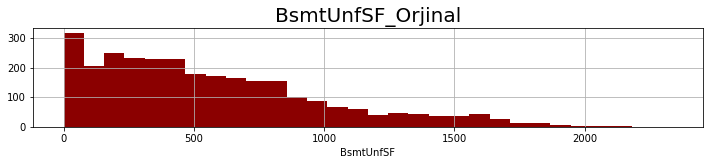

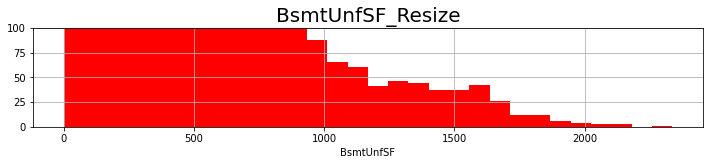

count    2918.000000
mean     1051.777587
std       440.766258
min         0.000000
5%        455.250000
20%       741.000000
40%       911.000000
50%       989.500000
60%      1089.200000
80%      1392.000000
90%      1614.000000
95%      1776.150000
99%      2198.300000
max      6110.000000
Name: TotalBsmtSF, dtype: float64


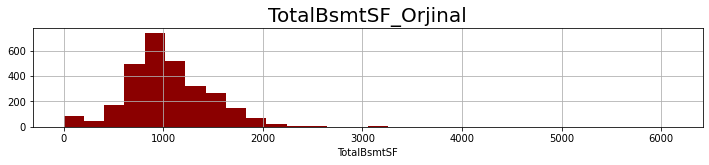

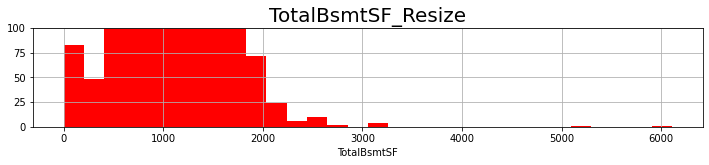

count    2919.000000
mean     1159.581706
std       392.362079
min       334.000000
5%        665.900000
20%       847.000000
40%       996.200000
50%      1082.000000
60%      1180.000000
80%      1483.400000
90%      1675.000000
95%      1830.100000
99%      2288.020000
max      5095.000000
Name: 1stFlrSF, dtype: float64


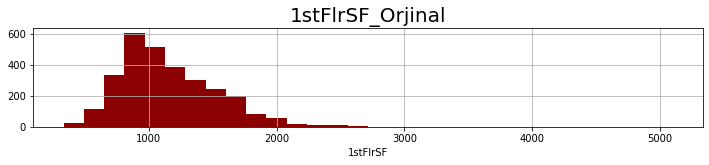

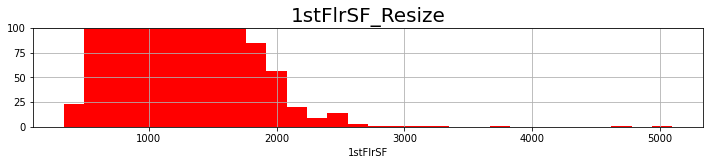

count    2919.000000
mean      336.483727
std       428.701456
min         0.000000
5%          0.000000
20%         0.000000
40%         0.000000
50%         0.000000
60%       427.400000
80%       770.800000
90%       925.000000
95%      1131.200000
99%      1400.200000
max      2065.000000
Name: 2ndFlrSF, dtype: float64


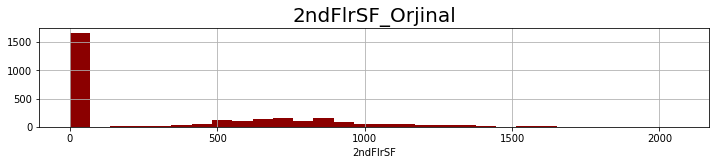

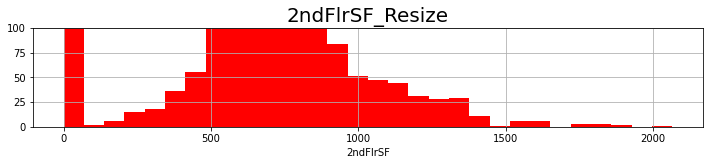

count    2919.000000
mean        4.694416
std        46.396825
min         0.000000
5%          0.000000
20%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%       153.840000
max      1064.000000
Name: LowQualFinSF, dtype: float64


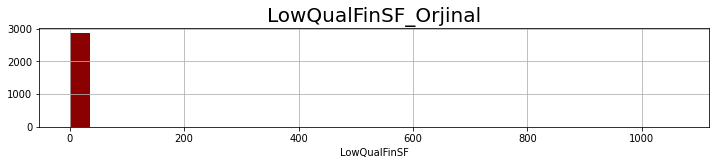

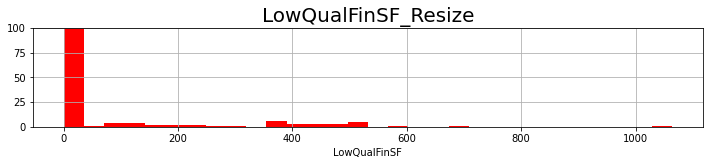

count    2919.000000
mean     1500.759849
std       506.051045
min       334.000000
5%        861.000000
20%      1064.600000
40%      1329.200000
50%      1444.000000
60%      1560.000000
80%      1838.400000
90%      2153.200000
95%      2464.200000
99%      2935.720000
max      5642.000000
Name: GrLivArea, dtype: float64


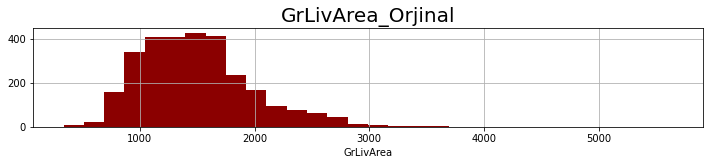

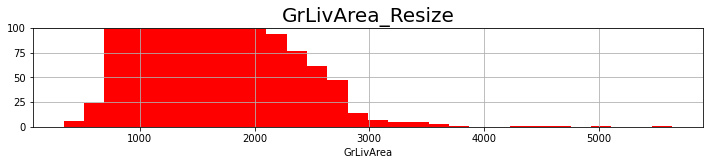

count    2919.000000
mean        6.451524
std         1.569379
min         2.000000
5%          4.000000
20%         5.000000
40%         6.000000
50%         6.000000
60%         7.000000
80%         8.000000
90%         8.000000
95%         9.000000
99%        11.000000
max        15.000000
Name: TotRmsAbvGrd, dtype: float64


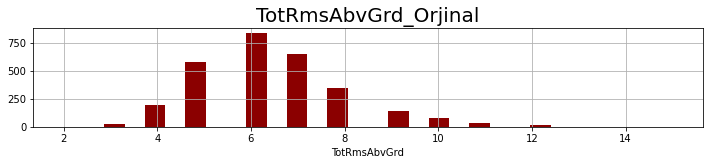

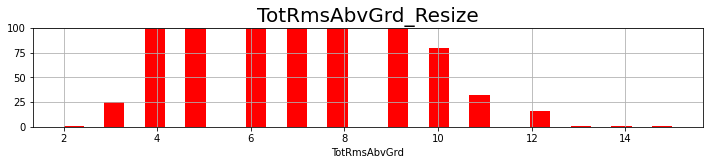

count    2760.000000
mean     1978.113406
std        25.574285
min      1895.000000
5%       1928.000000
20%      1957.000000
40%      1972.000000
50%      1979.000000
60%      1993.000000
80%      2004.000000
90%      2006.000000
95%      2007.000000
99%      2009.000000
max      2207.000000
Name: GarageYrBlt, dtype: float64


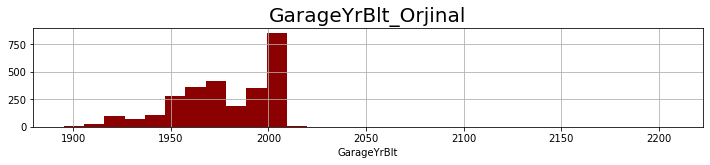

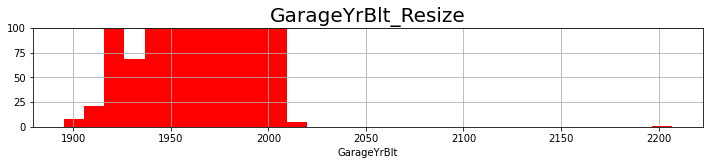

count    2918.000000
mean      472.874572
std       215.394815
min         0.000000
5%          0.000000
20%       296.000000
40%       440.000000
50%       480.000000
60%       513.000000
80%       621.000000
90%       758.000000
95%       856.150000
99%      1019.490000
max      1488.000000
Name: GarageArea, dtype: float64


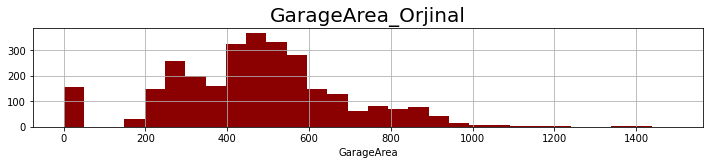

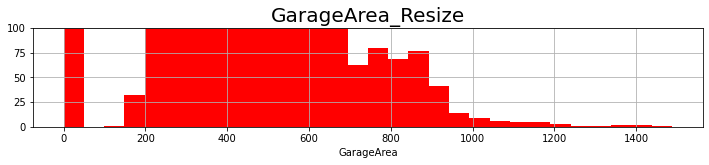

count    2919.000000
mean       93.709832
std       126.526589
min         0.000000
5%          0.000000
20%         0.000000
40%         0.000000
50%         0.000000
60%       100.000000
80%       192.000000
90%       257.000000
95%       328.000000
99%       500.820000
max      1424.000000
Name: WoodDeckSF, dtype: float64


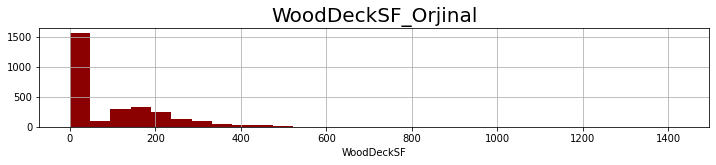

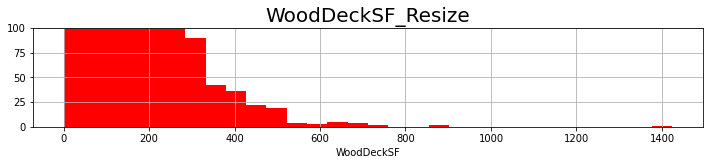

count    2919.000000
mean       47.486811
std        67.575493
min         0.000000
5%          0.000000
20%         0.000000
40%         0.000000
50%        26.000000
60%        40.000000
80%        85.000000
90%       131.200000
95%       183.100000
99%       284.460000
max       742.000000
Name: OpenPorchSF, dtype: float64


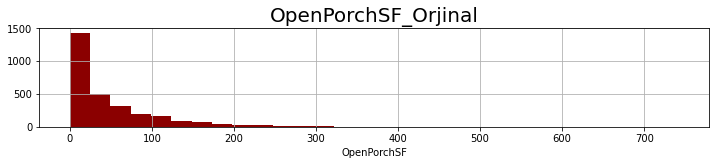

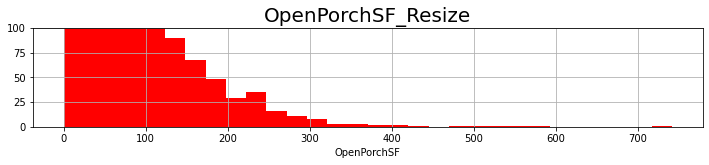

count    2919.000000
mean       23.098321
std        64.244246
min         0.000000
5%          0.000000
20%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
80%         0.000000
90%       112.000000
95%       176.000000
99%       264.000000
max      1012.000000
Name: EnclosedPorch, dtype: float64


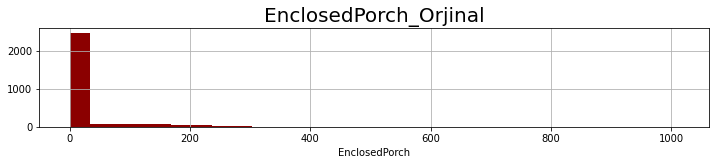

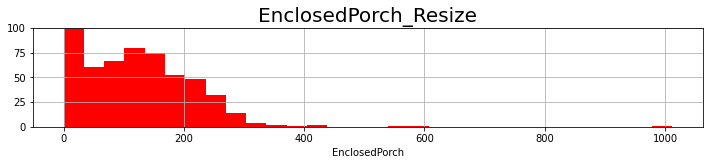

count    2919.000000
mean        2.602261
std        25.188169
min         0.000000
5%          0.000000
20%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%       144.000000
max       508.000000
Name: 3SsnPorch, dtype: float64


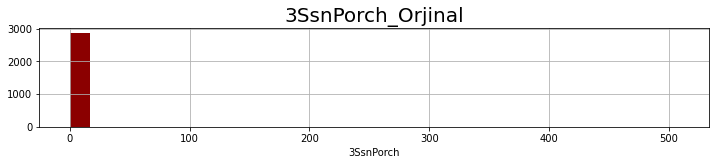

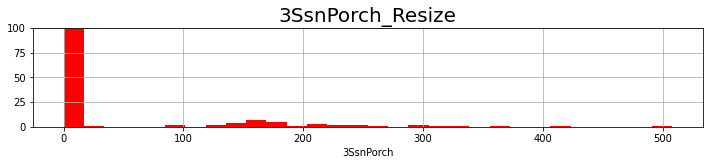

count    2919.000000
mean       16.062350
std        56.184365
min         0.000000
5%          0.000000
20%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
80%         0.000000
90%         0.000000
95%       161.000000
99%       259.820000
max       576.000000
Name: ScreenPorch, dtype: float64


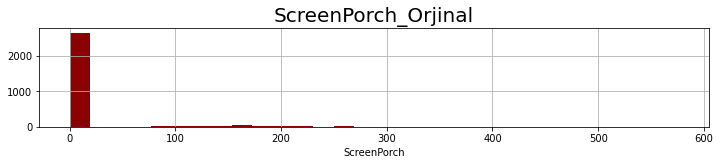

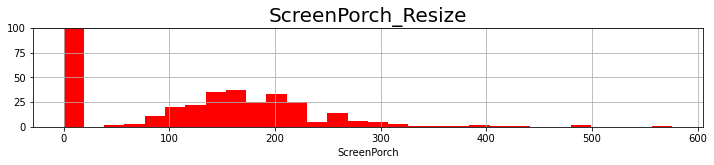

count    2919.000000
mean        2.251799
std        35.663946
min         0.000000
5%          0.000000
20%         0.000000
40%         0.000000
50%         0.000000
60%         0.000000
80%         0.000000
90%         0.000000
95%         0.000000
99%         0.000000
max       800.000000
Name: PoolArea, dtype: float64


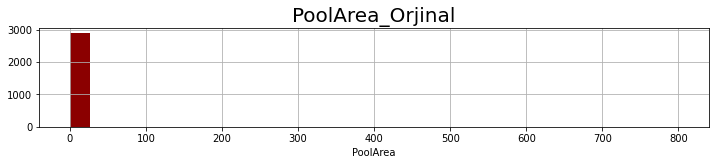

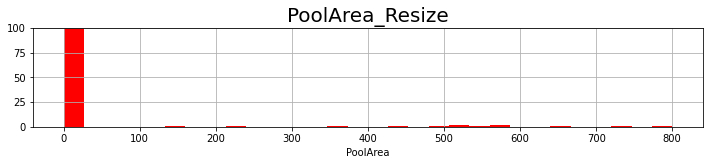

count     2919.000000
mean        50.825968
std        567.402211
min          0.000000
5%           0.000000
20%          0.000000
40%          0.000000
50%          0.000000
60%          0.000000
80%          0.000000
90%          0.000000
95%          0.000000
99%        982.000000
max      17000.000000
Name: MiscVal, dtype: float64


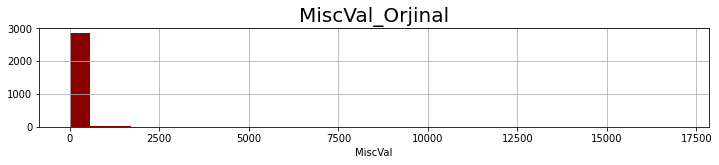

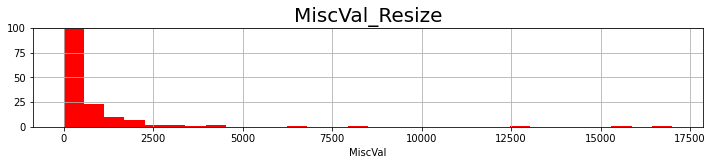

count    2919.000000
mean        6.213087
std         2.714762
min         1.000000
5%          2.000000
20%         4.000000
40%         6.000000
50%         6.000000
60%         7.000000
80%         8.000000
90%        10.000000
95%        11.000000
99%        12.000000
max        12.000000
Name: MoSold, dtype: float64


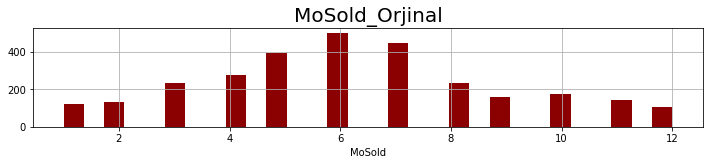

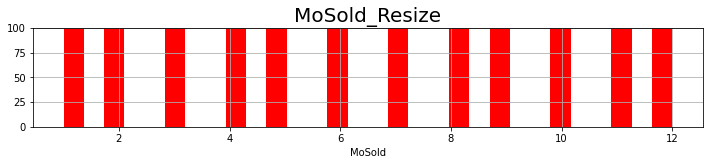

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
5%        88000.000000
20%      124000.000000
40%      147000.000000
50%      163000.000000
60%      179280.000000
80%      230000.000000
90%      278000.000000
95%      326100.000000
99%      442567.010000
max      755000.000000
Name: SalePrice, dtype: float64


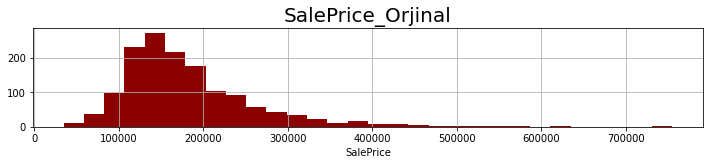

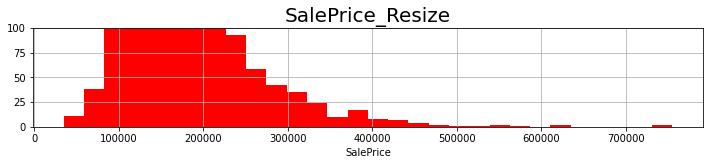

In [24]:
for col in num_cols:
    num_summary(df, col ,plot=True)

# <center> <h1 style="background-color:red; color:white" >Correlation Analysis &#128200;</h1><center>

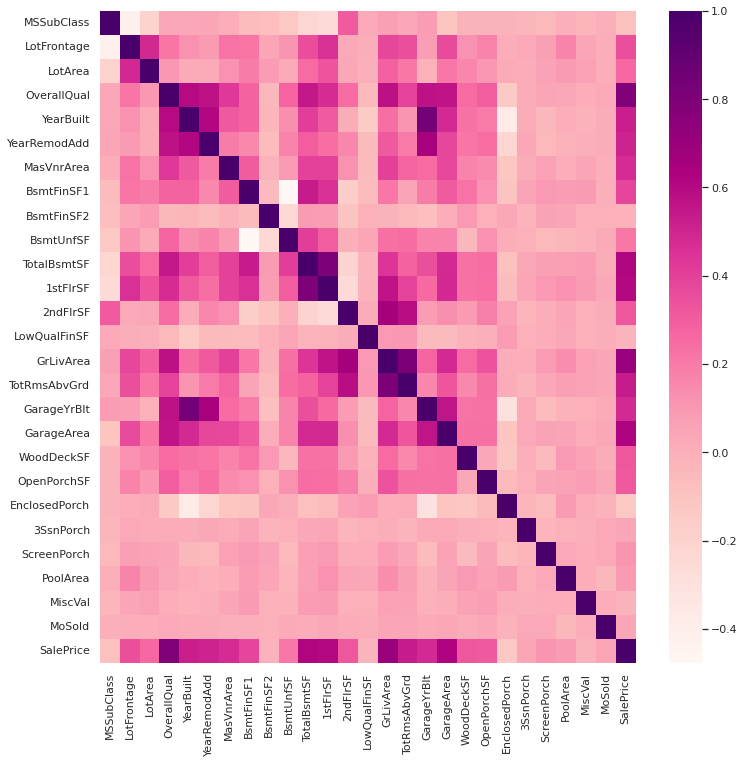

In [25]:
corr = df[num_cols].corr()

sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdPu")
plt.show(block=True)

In [26]:
high_correlated_cols(df, plot=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'SalePrice']

**Outlier Observation Analysis**

In [27]:
for col in num_cols:
    if col != "SalePrice":
      print(col, check_outlier(df, col))

MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd True
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
PoolArea True
MiscVal True
MoSold False


**Suppression of Outliers**

In [28]:
for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)

# <center> <h1 style="background-color:red; color:white" >MISSING VALUES &#128270;</h1><center>

In [29]:
missing_values_table(df)

              n_miss  ratio
PoolQC          2909  99.66
MiscFeature     2814  96.40
Alley           2721  93.22
Fence           2348  80.44
SalePrice       1459  49.98
FireplaceQu     1420  48.65
LotFrontage      486  16.65
GarageCond       159   5.45
GarageYrBlt      159   5.45
GarageFinish     159   5.45
GarageQual       159   5.45
GarageType       157   5.38
BsmtExposure      82   2.81
BsmtCond          82   2.81
BsmtQual          81   2.77
BsmtFinType2      80   2.74
BsmtFinType1      79   2.71
MasVnrType        24   0.82
MasVnrArea        23   0.79
MSZoning           4   0.14
Functional         2   0.07
BsmtHalfBath       2   0.07
BsmtFullBath       2   0.07
Utilities          2   0.07
KitchenQual        1   0.03
TotalBsmtSF        1   0.03
BsmtUnfSF          1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
BsmtFinSF2         1   0.03
BsmtFinSF1         1   0.03
Exterior2nd        1   0.03
Exterior1st        1   0.03
SaleType           1   0.03
Electrical         1

In [30]:
no_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]


# Filling the spaces in the columns with the expression "No"
for col in no_cols:
    df[col].fillna("No",inplace=True)

missing_values_table(df)

              n_miss  ratio
SalePrice       1459  49.98
LotFrontage      486  16.65
GarageYrBlt      159   5.45
MasVnrType        24   0.82
MasVnrArea        23   0.79
MSZoning           4   0.14
BsmtFullBath       2   0.07
BsmtHalfBath       2   0.07
Functional         2   0.07
Utilities          2   0.07
Exterior2nd        1   0.03
BsmtFinSF1         1   0.03
BsmtFinSF2         1   0.03
BsmtUnfSF          1   0.03
Exterior1st        1   0.03
Electrical         1   0.03
KitchenQual        1   0.03
GarageCars         1   0.03
GarageArea         1   0.03
SaleType           1   0.03
TotalBsmtSF        1   0.03


In [31]:
# Other Missing Values
df = quick_missing_imp(df, num_method="median", cat_length=17)

# BEFORE
MSZoning           4
LotFrontage      486
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
GarageYrBlt      159
GarageCars         1
GarageArea         1
SaleType           1
SalePrice       1459
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

MSZoning           0
LotFrontage        0
Utilities          0
Exterior1st        0
Exterior2nd        0
MasVnrType         0
MasVnrArea         0
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
Electrical         0
BsmtFullBath       0
BsmtHalfBath       0
KitchenQual        0
Functional         0
GarageYrBlt        0
GarageCars         0
GarageArea         0
SaleType      

**Rare:** MSZoning, LotShape, ExterCond, GarageQual, BsmtFinType2 , Condition1 , BldgType 

**Deleting:** Street, Alley, LandContour, Utilities, LandSlope, Condition2, Heating, CentralAir, Functional, PoolQC, MiscFeature, Neighborhood, KitchenAbvGr

# <center> <h1 style="background-color:red; color:white" >Rare Analyzer &#128270;</h1><center>

In [32]:
rare_analyser(df, "SalePrice", cat_cols)

MSZoning : 5
         COUNT     RATIO    TARGET_MEAN
C (all)     25  0.008565   74528.000000
FV         139  0.047619  214014.061538
RH          26  0.008907  131558.375000
RL        2269  0.777321  191004.994787
RM         460  0.157588  126316.830275


Street : 2
      COUNT     RATIO    TARGET_MEAN
Grvl     12  0.004111  130190.500000
Pave   2907  0.995889  181130.538514


Alley : 3
      COUNT     RATIO    TARGET_MEAN
Grvl    120  0.041110  122219.080000
No     2721  0.932169  183452.131483
Pave     78  0.026721  168000.585366


LotShape : 4
     COUNT     RATIO    TARGET_MEAN
IR1    968  0.331620  206101.665289
IR2     76  0.026036  239833.365854
IR3     16  0.005481  216036.500000
Reg   1859  0.636862  164754.818378


LandContour : 4
     COUNT     RATIO    TARGET_MEAN
Bnk    117  0.040082  143104.079365
HLS    120  0.041110  231533.940000
Low     60  0.020555  203661.111111
Lvl   2622  0.898253  180183.746758


Utilities : 2
        COUNT     RATIO   TARGET_MEAN
AllPub   2918  0

# <center> <h1 style="background-color:red; color:white" >Feature Engineering</h1><center>

**MSZoning** 

In [33]:
df["MSZoning"].value_counts()

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [34]:
df.loc[(df["MSZoning"] == "RH"), "MSZoning"] = "RM"
df.loc[(df["MSZoning"] == "FV"), "MSZoning"] = "FV + C (all)"
df.loc[(df["MSZoning"] == "C (all)"), "MSZoning"] = "FV + C (all)"
df["MSZoning"].value_counts()

RL              2269
RM               486
FV + C (all)     164
Name: MSZoning, dtype: int64

**Lot Area**


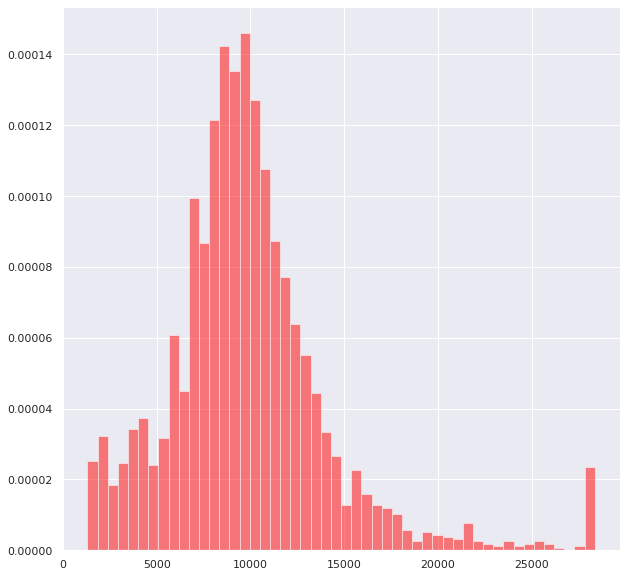

In [35]:
sns.set(rc={'figure.figsize': (10, 10)})
bins = 50
plt.hist(df["LotArea"],bins, alpha=0.5, density=True, color='red')
plt.show()

In [36]:
df["LotArea"].max()

28367.9

In [37]:
df['LotArea'].mean()

9818.098081534772

In [38]:
df['LotArea'].value_counts()

9600.0     44
7200.0     43
28367.9    37
6000.0     34
9000.0     29
           ..
15863.0     1
7082.0      1
9492.0      1
9300.0      1
10441.0     1
Name: LotArea, Length: 1915, dtype: int64

In [39]:
New_LotArea =  pd.Series(["Studio","Small", "Middle", "Large","Dublex","Luxury"], dtype = "category")
df["New_LotArea"] = New_LotArea
df.loc[(df["LotArea"] <= 2000), "New_LotArea"] = New_LotArea[0]
df.loc[(df["LotArea"] > 2000) & (df["LotArea"] <= 4000), "New_LotArea"] = New_LotArea[1]
df.loc[(df["LotArea"] > 4000) & (df["LotArea"] <= 6000), "New_LotArea"] = New_LotArea[2]
df.loc[(df["LotArea"] > 6000) & (df["LotArea"] <= 8000), "New_LotArea"] = New_LotArea[3]
df.loc[(df["LotArea"] > 10000) & (df["LotArea"] <= 12000), "New_LotArea"] = New_LotArea[4]
df.loc[df["LotArea"] > 12000 ,"New_LotArea"] = New_LotArea[5]

In [40]:
df["New_LotArea"].value_counts()

Luxury    624
Dublex    594
Large     463
Middle    216
Small     157
Studio     58
Name: New_LotArea, dtype: int64

**LotShape**

In [41]:
df["LotShape"].value_counts()

Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64

In [42]:
df.loc[(df["LotShape"] == "IR1"), "LotShape"] = "IR"
df.loc[(df["LotShape"] == "IR2"), "LotShape"] = "IR"
df.loc[(df["LotShape"] == "IR3"), "LotShape"] = "IR"

In [43]:
df["LotShape"].value_counts()

Reg    1859
IR     1060
Name: LotShape, dtype: int64

**ExterCond**



In [44]:
df["ExterCond"].value_counts()

TA    2538
Gd     299
Fa      67
Ex      12
Po       3
Name: ExterCond, dtype: int64

In [45]:
df["ExterCond"] = np.where(df.ExterCond.isin(["Fa", "Po"]), "FaPo", df["ExterCond"])
df["ExterCond"] = np.where(df.ExterCond.isin(["Ex", "Gd"]), "ExGd", df["ExterCond"])
df['ExterCond'].value_counts()

TA      2538
ExGd     311
FaPo      70
Name: ExterCond, dtype: int64

**GarageQual**

In [46]:
df['GarageQual'].value_counts()

TA    2604
No     159
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64

In [47]:
df["GarageQual"] = np.where(df.GarageQual.isin(["Fa", "Po"]), "FaPo", df["GarageQual"])
df["GarageQual"] = np.where(df.GarageQual.isin(["Ex", "Gd"]), "ExGd", df["GarageQual"])
df["GarageQual"] = np.where(df.GarageQual.isin(["ExGd", "TA"]), "ExGd", df["GarageQual"])
df['GarageQual'].value_counts()

ExGd    2631
No       159
FaPo     129
Name: GarageQual, dtype: int64

**BsmtFinType1** and **BsmtFinType2**

In [48]:
df['BsmtFinType1'].value_counts()

Unf    851
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
No      79
Name: BsmtFinType1, dtype: int64

In [49]:
df['BsmtFinType2'].value_counts()

Unf    2493
Rec     105
LwQ      87
No       80
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64

In [50]:
df["BsmtFinType1"] = np.where(df.BsmtFinType1.isin(["GLQ", "ALQ"]), "RareExcellent", df["BsmtFinType1"])
df["BsmtFinType1"] = np.where(df.BsmtFinType1.isin(["BLQ", "LwQ", "Rec"]), "RareGood", df["BsmtFinType1"])
df["BsmtFinType2"] = np.where(df.BsmtFinType2.isin(["GLQ", "ALQ"]), "RareExcellent", df["BsmtFinType2"])
df["BsmtFinType2"] = np.where(df.BsmtFinType2.isin(["BLQ", "LwQ", "Rec"]), "RareGood", df["BsmtFinType2"])
df['BsmtFinType1'].value_counts()

RareExcellent    1278
Unf               851
RareGood          711
No                 79
Name: BsmtFinType1, dtype: int64

In [51]:
df['BsmtFinType2'].value_counts()

Unf              2493
RareGood          260
RareExcellent      86
No                 80
Name: BsmtFinType2, dtype: int64

**Condition1**

In [52]:
df['Condition1'].value_counts()

Norm      2511
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64

In [53]:
df.loc[(df["Condition1"] == "Feedr") | (df["Condition1"] == "Artery") |(df["Condition1"] == "RRAn") |(df["Condition1"] == "PosA") | (df["Condition1"] == "RRAe"),"Condition1"] = "AdjacentCondition"
df.loc[(df["Condition1"] == "RRNn") | (df["Condition1"] == "PosN") |(df["Condition1"] == "RRNe"),"Condition1"] = "WithinCondition"
df.loc[(df["Condition1"] == "Norm") ,"Condition1"] = "NormalCondition"
df['Condition1'].value_counts()

NormalCondition      2511
AdjacentCondition     354
WithinCondition        54
Name: Condition1, dtype: int64

**Condition2**

In [54]:
df['Condition2'].value_counts()

Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

In [55]:
df.drop('Condition2',axis=1,inplace=True)

**BldgType**

In [56]:
df['BldgType'].value_counts()

1Fam      2425
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: BldgType, dtype: int64

In [57]:
df["BldgType"] = np.where(df.BldgType.isin(["1Fam", "2fmCon"]), "Normal", df["BldgType"])
df["BldgType"] = np.where(df.BldgType.isin(["TwnhsE", "Twnhs", "Duplex"]), "Big", df["BldgType"])
df['BldgType'].value_counts()

Normal    2487
Big        432
Name: BldgType, dtype: int64

**Electrical**

In [58]:
df["Electrical"].value_counts()

SBrkr    2672
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [59]:
df["Electrical"] = np.where(df.Electrical.isin(["FuseA", "FuseF", "FuseP", "Mix"]), "Fuse", df["Electrical"])
df["Electrical"].value_counts()

SBrkr    2672
Fuse      247
Name: Electrical, dtype: int64

**Paved Drive**

In [60]:
df["PavedDrive"].value_counts()

Y    2641
N     216
P      62
Name: PavedDrive, dtype: int64

In [61]:
df["PavedDrive"] = np.where(df.PavedDrive.isin(["N","P"]), "N", df["PavedDrive"])
df["PavedDrive"].value_counts()

Y    2641
N     278
Name: PavedDrive, dtype: int64

**Sale Type**

In [62]:
df["SaleType"].value_counts()

WD       2526
New       239
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [63]:
df["SaleType"] = np.where(df.SaleType.isin(["ConLw", "ConLI", "ConLD", "Oth",]), "Con", df["SaleType"])
df["SaleType"].value_counts()

WD     2526
New     239
COD      87
Con      55
CWD      12
Name: SaleType, dtype: int64

**Overall**

In [64]:
df["Overall"] = df[["OverallQual", "OverallCond"]].sum(axis = 1)

**NEW_TotalFlrSF**

Total surface area of the house

In [65]:
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"]

**NEW_TotalBsmtFin**

Completed total basement area

In [66]:
df["NEW_TotalBsmtFin"] = df.BsmtFinSF1+df.BsmtFinSF2

**NEW_PorchArea**

Total area outside the house

In [67]:
df["NEW_PorchArea"] = df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch + df["3SsnPorch"] + df.WoodDeckSF

**NEW_TotalHouseArea**

total area of the house

In [68]:
df["NEW_TotalHouseArea"] = df.NEW_TotalFlrSF + df.TotalBsmtSF

**NEW_TotalSqFeet**

Total occupancy of the house ft2

In [69]:
df["NEW_TotalSqFeet"] = df.GrLivArea + df.TotalBsmtSF

**NEW_TotalFullBath** and **NEW_TotalHalfBath**

Number of half and full bathrooms with the total in the house

In [70]:
df["NEW_TotalFullBath"] = df.BsmtFullBath + df.FullBath
df["NEW_TotalHalfBath"] = df.BsmtHalfBath + df.HalfBath

**NEW_TotalBath**

It represents the total number of bathrooms in the house.

In [71]:
df["NEW_TotalBath"] = df["NEW_TotalFullBath"] + (df["NEW_TotalHalfBath"]*0.5)

**Lot Ratio**

How much of the land is inhabited, total house area and garage area

In [72]:
df["NEW_LotRatio"] = df.GrLivArea / df.LotArea

df["NEW_RatioArea"] = df.NEW_TotalHouseArea / df.LotArea

df["NEW_GarageLotRatio"] = df.GarageArea / df.LotArea

**Differences between dates**

Variables such as the last year between the restoration and the year of construction, the difference between the year the garage was built and the year the house was built.

In [71]:
df["NEW_Restoration"] = df.YearRemodAdd - df.YearBuilt

df["NEW_HouseAge"] = df.YrSold - df.YearBuilt

df["NEW_RestorationAge"] = df.YrSold - df.YearRemodAdd

df["NEW_GarageAge"] = df.GarageYrBlt - df.YearBuilt

df["NEW_GarageRestorationAge"] = np.abs(df.GarageYrBlt - df.YearRemodAdd)

df["NEW_GarageSold"] = df.YrSold - df.GarageYrBlt

In [72]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,NEW_TotalBath,NEW_LotRatio,NEW_RatioArea,NEW_GarageLotRatio,NEW_Restoration,NEW_HouseAge,NEW_RestorationAge,NEW_GarageAge,NEW_GarageRestorationAge,NEW_GarageSold
0,1.0,60,RL,65.0,8450.0,Pave,No,Reg,Lvl,AllPub,...,3.5,0.202367,0.303669,0.064852,0.0,5,5.0,0.0,0.0,5.0
1,2.0,20,RL,80.0,9600.0,Pave,No,Reg,Lvl,AllPub,...,2.5,0.131458,0.262917,0.047917,0.0,31,31.0,0.0,0.0,31.0
2,3.0,60,RL,68.0,11250.0,Pave,No,IR,Lvl,AllPub,...,3.5,0.158756,0.240533,0.054044,1.0,7,6.0,0.0,1.0,7.0
3,4.0,70,RL,60.0,9550.0,Pave,No,IR,Lvl,AllPub,...,2.0,0.179791,0.258953,0.067225,55.0,91,36.0,83.0,28.0,8.0
4,5.0,60,RL,84.0,14260.0,Pave,No,IR,Lvl,AllPub,...,3.5,0.154137,0.234432,0.058626,0.0,8,8.0,0.0,0.0,8.0


**Extracting Data From Dataset**

In [73]:
drop_list = ["Street", "Alley", "LandContour", "Utilities" ,"LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood","KitchenAbvGr", "CentralAir", "Functional","RoofMatl",]

df.drop(drop_list, axis=1, inplace=True)

# <center> <h1 style="background-color:red; color:white" >Label Encoding and One Hot Encoder</h1><center>

In [74]:
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df)

Observations: 2919
Variables: 80
cat_cols: 47
num_cols: 33
cat_but_car: 0
num_but_cat: 17


In [75]:
def label_encoder(dataframe, binary_col):
    labelencoder = preprocessing.LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O"
               and len(df[col].unique()) == 2]

In [76]:
for col in binary_cols:
    label_encoder(df, col)

In [77]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [78]:
missing_values_table(df)

           n_miss  ratio
SalePrice    1459  49.98


# <center> <h1 style="background-color:red; color:white" >Regression Model</h1><center>

In [79]:
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()].drop("SalePrice", axis=1)

y = np.log1p(df[df['SalePrice'].notnull()]['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)

In [80]:
X

,MSSubClass,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,New_LotArea_Studio,NEW_TotalFullBath_1.0,NEW_TotalFullBath_2.0,NEW_TotalFullBath_3.0,NEW_TotalFullBath_4.0,NEW_TotalFullBath_6.0,NEW_TotalHalfBath_1.0,NEW_TotalHalfBath_2.0,NEW_TotalHalfBath_3.0,NEW_TotalHalfBath_4.0
0,60,65.0,8450.0,7.0,2003,2003.0,196.0,706.0,0.0,150.0,...,1,0,0,1,0,0,1,0,0,0
1,20,80.0,9600.0,6.0,1976,1976.0,0.0,978.0,0.0,284.0,...,0,0,1,0,0,0,1,0,0,0
2,60,68.0,11250.0,7.0,2001,2002.0,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,1,0,0,0
3,70,60.0,9550.0,7.0,1915,1970.0,0.0,216.0,0.0,540.0,...,0,0,1,0,0,0,0,0,0,0
4,60,84.0,14260.0,8.0,2000,2000.0,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917.0,6.0,1999,2000.0,0.0,0.0,0.0,953.0,...,0,0,1,0,0,0,1,0,0,0
1456,20,85.0,13175.0,6.0,1978,1988.0,119.0,790.0,163.0,589.0,...,0,0,0,1,0,0,0,0,0,0
1457,70,66.0,9042.0,7.0,1941,2006.0,0.0,275.0,0.0,877.0,...,0,0,1,0,0,0,0,0,0,0
1458,20,68.0,9717.0,5.0,1950,1996.0,0.0,49.0,314.0,0.0,...,0,0,1,0,0,0,0,0,0,0


In [81]:
y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1455    12.072547
1456    12.254868
1457    12.493133
1458    11.864469
1459    11.901590
Name: SalePrice, Length: 1460, dtype: float64

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

models = [('LR', LinearRegression()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

RMSE: 0.1547 (LR) 
RMSE: 0.2167 (KNN) 
RMSE: 0.2176 (CART) 
RMSE: 0.144 (RF) 
RMSE: 0.1288 (GBM) 
RMSE: 0.1444 (XGBoost) 
RMSE: 0.1357 (LightGBM) 


In [83]:
#Splitting the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [84]:
gbm_model = GradientBoostingRegressor(random_state=17)

rmse = np.mean(np.sqrt(-cross_val_score(gbm_model,
                                        X, y, cv=10, scoring="neg_mean_squared_error")))

gbm_params = {"learning_rate": [0.01, 0.04, 0.1],
                  "max_depth": [3, 4, 5, 6],
                  "n_estimators": [100, 200, 400, 800, 1000],
                  "subsample": [0.1, 0.4, 0.7, 1]}

gbm_best_params_ = GridSearchCV(gbm_model,
                            gbm_params,
                            cv=5,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [85]:
gbm_best_params_.best_params_

{'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.7}

In [86]:
final_model = gbm_model.set_params(**gbm_best_params_.best_params_).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))

In [87]:
round(rmse, 4)

0.1254

In [88]:
gbm_tuned = XGBRegressor(objective='reg:squarederror',**gbm_best_params_.best_params_).fit(X_train, y_train)
y_pred = gbm_tuned.predict(X_test)


# Getting the inverse of the LOG transformation made
new_y= np.expm1(y_pred)
new_y_test= np.expm1(y_test)

np.sqrt(mean_squared_error(new_y_test, new_y))


22303.31138213474

In [89]:
df['SalePrice'].mean()

180921.19589041095

In [90]:
submission_df = pd.DataFrame()
submission_df['Id'] = test_df["Id"].astype("Int32")

y_pred_sub = gbm_tuned.predict(test_df.drop("Id", axis=1))

y_pred_sub = np.expm1(y_pred_sub)

submission_df['SalePrice'] = y_pred_sub

submission_df.to_csv('submission.csv', index=False)

# THANK YOU